# This notebook is to show how to repreduce our results

Some terms we used:
1. factor: the elementary basis of the learned dictionary
2. word vector / embedding: the distributed word representations, context independent
3. activations: the non negative coefficients of the factors that forms a linear combination of word embeddings

#### Outline:
1. Load and process data
2. Train word factors
3. Visualization
4. Obtain cooccurrence matrix
5. Factor group visualization

In [1]:
import sys
import numpy as np
import numpy.linalg as la
from numpy.linalg import norm
import matplotlib.pyplot as plt
sys.path.append('./')
# import utility
import sparsify_PyTorch

import torch

In [2]:
torch.cuda.set_device(0)

# Note: 

In this notebook, we use **text8** and **GloVe** as an example. They are all publicly available and commonly used on the internet. 

1. text8 is publicly available online. I have lost the original downloading address but you can download it from: http://mattmahoney.net/dc/text8.zip and unzip it to `./data/`

2. You can find pretrained GloVe embeddings from the website https://nlp.stanford.edu/projects/glove/. Please download and unzip it to the corresponding directory `./embeddings/`

## Step 1. Load and preprocess corpus data and embeddings

In [3]:
#data_path = "./"
data_path = "./data/"

In [8]:
text8 = open(data_path + 'text8').read()
text8_list = text8.split()
vocabulary_list = list(set(text8_list))
print(len(vocabulary_list))
histogram = {}
for token in text8_list:
    histogram[token] =  histogram.get(token,0) + 1
vocabulary_list = histogram.keys()
vocabulary_count = np.array(list(histogram.values()))
COUNT_THRESHOLD = 5 # minimum freq

253854


In [9]:
# filter out tokens with freq < threshold
hist_reduced = {}
for token in vocabulary_list:
    if histogram.get(token,0) >= COUNT_THRESHOLD:
        hist_reduced[token] =  histogram[token]
vocList_reduced = hist_reduced.keys()
vocCount_reduced = np.array(list(hist_reduced.values()))
print(len(vocList_reduced))

71290


GloVe embeddings

In [1]:
#embedding_path = "./"
# embedding_path = "../../glove/"
embedding_path = "./embeddings/"
glove_file = embedding_path + 'glove.840B.300d.txt'

In [11]:
# glove 
# glove_file = embedding_path + 'glove.840B.300d.txt'
def load_pretrained_embd(file, vocab):
    embeddings={}
    dim = None
    for line in open(file,'r'):
        line = line.strip().split()
        if dim==None:
            dim = len(line)-1
            assert dim == 300
        else:
            if len(line) != dim+1:
                continue
        if line[0] in vocab:
            rep = np.array([float(v) for v in line[1:]], dtype='float32')
            embeddings[line[0]] = rep
    return embeddings
embeddings = load_pretrained_embd(glove_file, vocList_reduced)

In [12]:
len(embeddings)
vocList_embedded = embeddings.keys()
hist_embeded = {}
for word in vocList_embedded:
    hist_embeded[word] = hist_reduced[word]
vocCount_embeded = np.array(list(hist_embeded.values()))
vocab_idx = {}
idx_vocab = {}
# construct idx embeddings for effiency
idx_embeddings=np.zeros((300,len(vocList_embedded)), dtype='float32')
# simoutanously populate it during iteration
for idx, tok in enumerate(vocList_embedded):
    vocab_idx[tok] = idx
    idx_embeddings[:, idx] = embeddings[tok]
idx_vocab = {idx : tok for tok, idx in vocab_idx.items()}
print(len(vocab_idx))

63167


In [13]:
text8_hash_seq = np.zeros(vocCount_embeded.sum()).astype('int')
idx = 0
for token in text8_list:
    if token in vocList_embedded:
        text8_hash_seq[idx] = vocab_idx[token]
        idx = idx+1
# text8_hash_seq: seq idx -> word in vocab_embeded
print(text8_hash_seq.shape)

(16632605,)


In [14]:
prob = np.log(vocCount_embeded)/np.log(vocCount_embeded).sum()

## Step 2. word factor training

In [5]:
def word_batching(idx_embeddings, vochash, prob, batch_size=100, iftext=False):
    '''
    Random sample words directly from vocabulary, construct the batch using their embeddings.
    Sample probability is determined by word frequency in corpora
    '''
    batch_text=[]
    choose_idx = np.random.choice(np.arange(idx_embeddings.shape[1]), size=batch_size, p=prob)
    if iftext:
        for idx in choose_idx.tolist():
            batch_text.append(vochash[idx])
    return idx_embeddings[:,choose_idx], batch_text

In [7]:
def weighted_batching(seqhash, vochash, voccount, idx_embeddings, batch_size=100, window=10, a=1e-3, iftext=False):
    '''
    Random sample ONE BATCH of context window from text8 hash seq.
    Return FREQ PROB WEIGHTED BoW vectors and if iftext==true, batch_text.
    '''
    voccount = voccount/voccount.sum() # freqs -> probs
    cen_words = np.random.choice(np.arange(window, seqhash.shape[0] - window), batch_size)
    batch_context = []
    batch_BoW = np.zeros((idx_embeddings.shape[0], batch_size), dtype="float32")
    for bid, cw in enumerate(cen_words.tolist()):
        context = seqhash[cw-window: cw+window+1] # (context, center word, context) 2*context+1 seq
        assert len(context)!=0, cw
        # retrieve word vectors and WEIGHTED sum along axis 1 into BoW vector
        weights = a/(a+voccount[context])
        batch_BoW[:, bid] = (idx_embeddings[:, context]*(weights)).sum(axis=1)
        # to hash word idx
        if iftext:
            context_word = [vochash[w] for w in context]
            batch_context.append(context_word)    
    return batch_BoW, batch_context

6.9005594


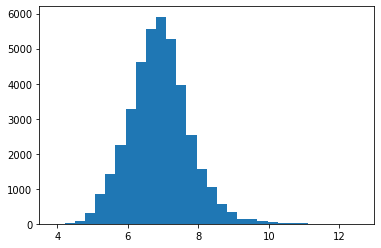

In [19]:
# estimate BoW vetor norm
total=40000
batch_BoW, _ = word_batching(idx_embeddings, idx_vocab, prob, batch_size=total, iftext=False)
BoW_norm = np.linalg.norm(batch_BoW, axis=0)
print(BoW_norm.mean())
plt.hist(BoW_norm, bins=30)
plt.show()

In [16]:
word_factor_dir = "./results/glove-text8-reproduce-1k-factors/"

In [20]:
NORM = BoW_norm.mean() / 10.
print(NORM)

0.6900559425354004


**Training starts here**

In [21]:
BASIS1_NUM = 1000 #1500 #1000# for word(context=0), use 2000
BASIS1_SIZE = [idx_embeddings.shape[0], BASIS1_NUM]

dtype = torch.cuda.FloatTensor
basis1 = torch.randn(BASIS1_SIZE).type(dtype)
basis1 = basis1.div_(basis1.norm(2,0))

# basis1 = torch.load("../results/word-1000-step200k-lambd05/basis1").type(dtype)

lambd = 0.5#0.8 # 0.5
STEPS = 200000

ACT_HISTORY_LEN = 100
# Hessian = torch.zeros(BASIS1_NUM,BASIS1_NUM).type(dtype)
HessianDiag = torch.zeros(BASIS1_NUM).type(dtype)
ActL1 = torch.zeros(BASIS1_NUM).type(dtype)
signalEnergy = 0.
noiseEnergy = 0.
NORM = 0.69 #0.104#0.375#0.72#1.64 #for word2vec cbow #0.448 for word2vec skipgram #0.037 for pretrained fastext # 0.72 for glove estimated norm/10
i = 0
BATCHSIZE=100

In [22]:
xx = i
curve=[]
for i in range(xx,STEPS):
    batch_data, batch_txt = word_batching(idx_embeddings, idx_vocab, prob, batch_size=BATCHSIZE, iftext=False)
    
    
    I_cuda = torch.from_numpy(batch_data).div(NORM).cuda()
    #Inference
#     ahat1, Res1 = sparsify_PyTorch.ISTA(I_cuda, basis1, lambd, 1000)
    ahat1, Res1 = sparsify_PyTorch.FISTA(I_cuda, basis1, lambd, 500)
    
    # Training
    ActL1 = ActL1.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + ahat1.mean(1)/ACT_HISTORY_LEN
    HessianDiag = HessianDiag.mul((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(ahat1,2).mean(1)/ACT_HISTORY_LEN
    basis1 = sparsify_PyTorch.quadraticBasisUpdate(basis1, Res1, ahat1, 0.001, HessianDiag, 0.0005)
    
    #  Statistics
    signalEnergy = signalEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(I_cuda,2).sum()/ACT_HISTORY_LEN
    noiseEnergy = noiseEnergy*((ACT_HISTORY_LEN-1.0)/ACT_HISTORY_LEN) + torch.pow(Res1,2).sum()/ACT_HISTORY_LEN
    snr = signalEnergy/noiseEnergy
    
    #print(i)
    actmin = ActL1.min().item()
    actmax = ActL1.max().item()
    actmean = ActL1.mean().item()
    
    if i % 100 == 0:
        sparsity_loss = ActL1.sum() * lambd
        loss = 0.5*noiseEnergy/BATCHSIZE + sparsity_loss
        temp = ActL1.sort(descending=True)[0]
        deadUnitCount = temp[temp<1e-6].size()
        print(i, 'snr:', snr.item(), 'DeadUnit', deadUnitCount, 'Hmin:', HessianDiag.min().item(), 'Hmax:', HessianDiag.max().item(), 
              'ActL1min:', actmin, 'ActL1max:', actmax, 'ActL1mean:', actmean, 'Loss', loss.item(), 'sparsity loss', sparsity_loss.item())
        curve.append((actmin, actmax, actmean))
    

0 snr: 2.1380667686462402 DeadUnit torch.Size([6]) Hmin: 0.0 Hmax: 0.0011651171371340752 ActL1min: 0.0 ActL1max: 0.0017605258617550135 ActL1mean: 0.0003240624500904232 Loss 0.3960890769958496 sparsity loss 0.16203121840953827
100 snr: 2.8705177307128906 DeadUnit torch.Size([0]) Hmin: 0.00573493167757988 Hmax: 0.029848383739590645 ActL1min: 0.011911948211491108 ActL1max: 0.04563545435667038 ActL1mean: 0.02051890268921852 Loss 21.502206802368164 sparsity loss 10.259450912475586
200 snr: 2.971250534057617 DeadUnit torch.Size([0]) Hmin: 0.008439511992037296 Hmax: 0.04256207123398781 ActL1min: 0.017537983134388924 ActL1max: 0.055269308388233185 ActL1mean: 0.027355985715985298 Loss 28.46103858947754 sparsity loss 13.67799186706543
300 snr: 3.048111915588379 DeadUnit torch.Size([0]) Hmin: 0.009137159213423729 Hmax: 0.043799132108688354 ActL1min: 0.01897214725613594 ActL1max: 0.05734444037079811 ActL1mean: 0.02952813170850277 Loss 30.553791046142578 sparsity loss 14.76406478881836
400 snr: 3.1

3300 snr: 3.758964776992798 DeadUnit torch.Size([0]) Hmin: 0.009810969233512878 Hmax: 0.08311953395605087 ActL1min: 0.018107371404767036 ActL1max: 0.051735978573560715 ActL1mean: 0.02594141848385334 Loss 26.418521881103516 sparsity loss 12.970708847045898
3400 snr: 3.771700620651245 DeadUnit torch.Size([0]) Hmin: 0.009305986575782299 Hmax: 0.08203727006912231 ActL1min: 0.01814672164618969 ActL1max: 0.048777397722005844 ActL1mean: 0.025901665911078453 Loss 26.364810943603516 sparsity loss 12.95083236694336
3500 snr: 3.787736415863037 DeadUnit torch.Size([0]) Hmin: 0.00985636655241251 Hmax: 0.0802229642868042 ActL1min: 0.01871429570019245 ActL1max: 0.04884080961346626 ActL1mean: 0.02584560215473175 Loss 26.289852142333984 sparsity loss 12.922800064086914
3600 snr: 3.7993569374084473 DeadUnit torch.Size([0]) Hmin: 0.00929870642721653 Hmax: 0.07987434417009354 ActL1min: 0.018465805798768997 ActL1max: 0.04984678700566292 ActL1mean: 0.025811154395341873 Loss 26.251678466796875 sparsity loss 

6600 snr: 4.066704273223877 DeadUnit torch.Size([0]) Hmin: 0.009054823778569698 Hmax: 0.10771036893129349 ActL1min: 0.016121208667755127 ActL1max: 0.05589990317821503 ActL1mean: 0.024542002007365227 Loss 24.728334426879883 sparsity loss 12.271000862121582
6700 snr: 4.077744007110596 DeadUnit torch.Size([0]) Hmin: 0.008961685001850128 Hmax: 0.1176515743136406 ActL1min: 0.015488832257688046 ActL1max: 0.05538449063897133 ActL1mean: 0.024516450241208076 Loss 24.70162582397461 sparsity loss 12.258224487304688
6800 snr: 4.083797454833984 DeadUnit torch.Size([0]) Hmin: 0.009296475909650326 Hmax: 0.10196643322706223 ActL1min: 0.01619686186313629 ActL1max: 0.05345001444220543 ActL1mean: 0.02455468289554119 Loss 24.709922790527344 sparsity loss 12.27734088897705
6900 snr: 4.093177795410156 DeadUnit torch.Size([0]) Hmin: 0.009325345978140831 Hmax: 0.10690637677907944 ActL1min: 0.016384124755859375 ActL1max: 0.05569692328572273 ActL1mean: 0.024549061432480812 Loss 24.67342758178711 sparsity loss 1

9900 snr: 4.229979038238525 DeadUnit torch.Size([0]) Hmin: 0.009146755561232567 Hmax: 0.12049119919538498 ActL1min: 0.016100138425827026 ActL1max: 0.05703645199537277 ActL1mean: 0.023922577500343323 Loss 23.944194793701172 sparsity loss 11.961288452148438
10000 snr: 4.231457233428955 DeadUnit torch.Size([0]) Hmin: 0.009275502525269985 Hmax: 0.10827506333589554 ActL1min: 0.01616562344133854 ActL1max: 0.05801568925380707 ActL1mean: 0.023925496265292168 Loss 23.931507110595703 sparsity loss 11.962747573852539
10100 snr: 4.227443218231201 DeadUnit torch.Size([0]) Hmin: 0.009826715104281902 Hmax: 0.11181004345417023 ActL1min: 0.015824103727936745 ActL1max: 0.0543159618973732 ActL1mean: 0.023968923836946487 Loss 23.97311019897461 sparsity loss 11.984461784362793
10200 snr: 4.229503154754639 DeadUnit torch.Size([0]) Hmin: 0.008930878713726997 Hmax: 0.09980399906635284 ActL1min: 0.016431713476777077 ActL1max: 0.058180585503578186 ActL1mean: 0.023860696703195572 Loss 23.8724365234375 sparsity l

13200 snr: 4.329909801483154 DeadUnit torch.Size([0]) Hmin: 0.008888354524970055 Hmax: 0.11311586946249008 ActL1min: 0.014956747181713581 ActL1max: 0.056824106723070145 ActL1mean: 0.023591386154294014 Loss 23.506595611572266 sparsity loss 11.795692443847656
13300 snr: 4.32356071472168 DeadUnit torch.Size([0]) Hmin: 0.008676966652274132 Hmax: 0.11040844768285751 ActL1min: 0.015386574901640415 ActL1max: 0.057755082845687866 ActL1mean: 0.023646648973226547 Loss 23.564781188964844 sparsity loss 11.823324203491211
13400 snr: 4.333130359649658 DeadUnit torch.Size([0]) Hmin: 0.008050716482102871 Hmax: 0.11863522976636887 ActL1min: 0.01547146961092949 ActL1max: 0.05663008242845535 ActL1mean: 0.02359536848962307 Loss 23.503761291503906 sparsity loss 11.797683715820312
13500 snr: 4.32845401763916 DeadUnit torch.Size([0]) Hmin: 0.008346328511834145 Hmax: 0.11774265766143799 ActL1min: 0.014721611514687538 ActL1max: 0.05666719749569893 ActL1mean: 0.023600716143846512 Loss 23.522375106811523 sparsit

16400 snr: 4.381004810333252 DeadUnit torch.Size([0]) Hmin: 0.008957181125879288 Hmax: 0.12648427486419678 ActL1min: 0.014545129612088203 ActL1max: 0.05451786890625954 ActL1mean: 0.023409144952893257 Loss 23.29058837890625 sparsity loss 11.704571723937988
16500 snr: 4.376846790313721 DeadUnit torch.Size([0]) Hmin: 0.008784007281064987 Hmax: 0.11099398136138916 ActL1min: 0.014461000449955463 ActL1max: 0.05552453175187111 ActL1mean: 0.023464730009436607 Loss 23.334056854248047 sparsity loss 11.732364654541016
16600 snr: 4.374958515167236 DeadUnit torch.Size([0]) Hmin: 0.008520013652741909 Hmax: 0.12054738402366638 ActL1min: 0.01461375318467617 ActL1max: 0.05747469142079353 ActL1mean: 0.023439012467861176 Loss 23.30219268798828 sparsity loss 11.719505310058594
16700 snr: 4.381272792816162 DeadUnit torch.Size([0]) Hmin: 0.008898148313164711 Hmax: 0.10725406557321548 ActL1min: 0.015029453672468662 ActL1max: 0.058212004601955414 ActL1mean: 0.023303907364606857 Loss 23.174869537353516 sparsit

19700 snr: 4.411804676055908 DeadUnit torch.Size([0]) Hmin: 0.009228475391864777 Hmax: 0.09951005131006241 ActL1min: 0.014802119694650173 ActL1max: 0.056791018694639206 ActL1mean: 0.02325757034122944 Loss 23.120655059814453 sparsity loss 11.6287841796875
19800 snr: 4.4031524658203125 DeadUnit torch.Size([0]) Hmin: 0.009233291260898113 Hmax: 0.1075272411108017 ActL1min: 0.015325259417295456 ActL1max: 0.05606289207935333 ActL1mean: 0.02329045906662941 Loss 23.164310455322266 sparsity loss 11.64522933959961
19900 snr: 4.406120300292969 DeadUnit torch.Size([0]) Hmin: 0.009453684091567993 Hmax: 0.10560714453458786 ActL1min: 0.014587396755814552 ActL1max: 0.05431100353598595 ActL1mean: 0.023303251713514328 Loss 23.15148162841797 sparsity loss 11.651625633239746
20000 snr: 4.405993461608887 DeadUnit torch.Size([0]) Hmin: 0.009028096683323383 Hmax: 0.10597791522741318 ActL1min: 0.015296503901481628 ActL1max: 0.05443009361624718 ActL1mean: 0.02326267398893833 Loss 23.120532989501953 sparsity lo

23000 snr: 4.424851417541504 DeadUnit torch.Size([0]) Hmin: 0.008812759071588516 Hmax: 0.10880650579929352 ActL1min: 0.012427106499671936 ActL1max: 0.05273561552166939 ActL1mean: 0.023165816441178322 Loss 23.024267196655273 sparsity loss 11.582907676696777
23100 snr: 4.442558765411377 DeadUnit torch.Size([0]) Hmin: 0.008924965746700764 Hmax: 0.10706853121519089 ActL1min: 0.014415204524993896 ActL1max: 0.05459285154938698 ActL1mean: 0.023114202544093132 Loss 22.9606990814209 sparsity loss 11.557100296020508
23200 snr: 4.4288835525512695 DeadUnit torch.Size([0]) Hmin: 0.009343988262116909 Hmax: 0.10013014078140259 ActL1min: 0.015157762914896011 ActL1max: 0.05310363322496414 ActL1mean: 0.023189779371023178 Loss 23.045019149780273 sparsity loss 11.594888687133789
23300 snr: 4.440600872039795 DeadUnit torch.Size([0]) Hmin: 0.009260605089366436 Hmax: 0.09950056672096252 ActL1min: 0.014880074188113213 ActL1max: 0.05294099822640419 ActL1mean: 0.023151487112045288 Loss 22.981624603271484 sparsi

26200 snr: 4.452570915222168 DeadUnit torch.Size([0]) Hmin: 0.009471113793551922 Hmax: 0.13085409998893738 ActL1min: 0.01571347378194332 ActL1max: 0.048881299793720245 ActL1mean: 0.023148365318775177 Loss 22.985198974609375 sparsity loss 11.574182510375977
26300 snr: 4.441342353820801 DeadUnit torch.Size([0]) Hmin: 0.009142505005002022 Hmax: 0.09444195032119751 ActL1min: 0.014550465159118176 ActL1max: 0.051464419811964035 ActL1mean: 0.023111792281270027 Loss 22.960548400878906 sparsity loss 11.555895805358887
26400 snr: 4.454610347747803 DeadUnit torch.Size([0]) Hmin: 0.008953172713518143 Hmax: 0.09606210887432098 ActL1min: 0.014366047456860542 ActL1max: 0.048940885812044144 ActL1mean: 0.02305470034480095 Loss 22.888317108154297 sparsity loss 11.527349472045898
26500 snr: 4.444386005401611 DeadUnit torch.Size([0]) Hmin: 0.008874754421412945 Hmax: 0.09734056890010834 ActL1min: 0.014380221255123615 ActL1max: 0.0511791855096817 ActL1mean: 0.022977326065301895 Loss 22.838481903076172 spars

29500 snr: 4.476237773895264 DeadUnit torch.Size([0]) Hmin: 0.008589845150709152 Hmax: 0.10050123929977417 ActL1min: 0.014298445545136929 ActL1max: 0.05432902276515961 ActL1mean: 0.022994186729192734 Loss 22.812152862548828 sparsity loss 11.497093200683594
29600 snr: 4.457510471343994 DeadUnit torch.Size([0]) Hmin: 0.009215040132403374 Hmax: 0.10408743470907211 ActL1min: 0.013014879077672958 ActL1max: 0.0541478767991066 ActL1mean: 0.02303381636738777 Loss 22.87466049194336 sparsity loss 11.516907691955566
29700 snr: 4.465463638305664 DeadUnit torch.Size([0]) Hmin: 0.009344571270048618 Hmax: 0.0940040647983551 ActL1min: 0.015266678296029568 ActL1max: 0.05102061480283737 ActL1mean: 0.02301063947379589 Loss 22.850139617919922 sparsity loss 11.505319595336914
29800 snr: 4.46901798248291 DeadUnit torch.Size([0]) Hmin: 0.009802027605473995 Hmax: 0.09861037880182266 ActL1min: 0.01411818340420723 ActL1max: 0.051131706684827805 ActL1mean: 0.023091981187462807 Loss 22.92240333557129 sparsity los

32800 snr: 4.4748921394348145 DeadUnit torch.Size([0]) Hmin: 0.00943637266755104 Hmax: 0.1058439314365387 ActL1min: 0.01487693190574646 ActL1max: 0.0521448589861393 ActL1mean: 0.022983981296420097 Loss 22.808563232421875 sparsity loss 11.491990089416504
32900 snr: 4.487848281860352 DeadUnit torch.Size([0]) Hmin: 0.009342476725578308 Hmax: 0.11723244935274124 ActL1min: 0.014059381559491158 ActL1max: 0.05244630202651024 ActL1mean: 0.02301492914557457 Loss 22.834697723388672 sparsity loss 11.507464408874512
33000 snr: 4.4794182777404785 DeadUnit torch.Size([0]) Hmin: 0.009425411000847816 Hmax: 0.11187757551670074 ActL1min: 0.01509829144924879 ActL1max: 0.054012853652238846 ActL1mean: 0.022936230525374413 Loss 22.779003143310547 sparsity loss 11.468114852905273
33100 snr: 4.469482898712158 DeadUnit torch.Size([0]) Hmin: 0.009365350939333439 Hmax: 0.10686319321393967 ActL1min: 0.014483864419162273 ActL1max: 0.052295126020908356 ActL1mean: 0.02298177406191826 Loss 22.821847915649414 sparsity

36000 snr: 4.492340087890625 DeadUnit torch.Size([0]) Hmin: 0.009313489310443401 Hmax: 0.10032308101654053 ActL1min: 0.014212939888238907 ActL1max: 0.05028531327843666 ActL1mean: 0.022833287715911865 Loss 22.661388397216797 sparsity loss 11.416643142700195
36100 snr: 4.48225736618042 DeadUnit torch.Size([0]) Hmin: 0.009059593081474304 Hmax: 0.09821008145809174 ActL1min: 0.015259500592947006 ActL1max: 0.049044977873563766 ActL1mean: 0.022835208103060722 Loss 22.687679290771484 sparsity loss 11.417603492736816
36200 snr: 4.501413822174072 DeadUnit torch.Size([0]) Hmin: 0.00945540051907301 Hmax: 0.10692500323057175 ActL1min: 0.0147960614413023 ActL1max: 0.050794344395399094 ActL1mean: 0.022853909060359 Loss 22.677539825439453 sparsity loss 11.42695426940918
36300 snr: 4.48909330368042 DeadUnit torch.Size([0]) Hmin: 0.009849346242845058 Hmax: 0.0998188704252243 ActL1min: 0.014287515543401241 ActL1max: 0.049382444471120834 ActL1mean: 0.022899316623806953 Loss 22.741657257080078 sparsity los

39300 snr: 4.48287296295166 DeadUnit torch.Size([0]) Hmin: 0.009258154779672623 Hmax: 0.103249691426754 ActL1min: 0.014615853317081928 ActL1max: 0.04982590302824974 ActL1mean: 0.02287588268518448 Loss 22.739238739013672 sparsity loss 11.43794059753418
39400 snr: 4.495668888092041 DeadUnit torch.Size([0]) Hmin: 0.008820145390927792 Hmax: 0.10087734460830688 ActL1min: 0.015019821003079414 ActL1max: 0.050297390669584274 ActL1mean: 0.022878572344779968 Loss 22.708351135253906 sparsity loss 11.439285278320312
39500 snr: 4.486434459686279 DeadUnit torch.Size([0]) Hmin: 0.008076438680291176 Hmax: 0.1041705310344696 ActL1min: 0.015027225948870182 ActL1max: 0.049302227795124054 ActL1mean: 0.022915441542863846 Loss 22.76371192932129 sparsity loss 11.457719802856445
39600 snr: 4.493319034576416 DeadUnit torch.Size([0]) Hmin: 0.009731915779411793 Hmax: 0.10653222352266312 ActL1min: 0.014996279031038284 ActL1max: 0.05025589466094971 ActL1mean: 0.022913282737135887 Loss 22.75664520263672 sparsity lo

42600 snr: 4.4899983406066895 DeadUnit torch.Size([0]) Hmin: 0.009676562622189522 Hmax: 0.09881193935871124 ActL1min: 0.01563776284456253 ActL1max: 0.050835542380809784 ActL1mean: 0.022813113406300545 Loss 22.684202194213867 sparsity loss 11.406556129455566
42700 snr: 4.501001834869385 DeadUnit torch.Size([0]) Hmin: 0.00973760150372982 Hmax: 0.09796027094125748 ActL1min: 0.015332678332924843 ActL1max: 0.050177138298749924 ActL1mean: 0.02282140403985977 Loss 22.68383026123047 sparsity loss 11.410701751708984
42800 snr: 4.498405933380127 DeadUnit torch.Size([0]) Hmin: 0.009714068844914436 Hmax: 0.1091155856847763 ActL1min: 0.015403615310788155 ActL1max: 0.05140499770641327 ActL1mean: 0.022861450910568237 Loss 22.71031951904297 sparsity loss 11.43072509765625
42900 snr: 4.51486349105835 DeadUnit torch.Size([0]) Hmin: 0.00831792876124382 Hmax: 0.11133526265621185 ActL1min: 0.014759590849280357 ActL1max: 0.05118005350232124 ActL1mean: 0.02277742326259613 Loss 22.605587005615234 sparsity los

45900 snr: 4.505112171173096 DeadUnit torch.Size([0]) Hmin: 0.009242886677384377 Hmax: 0.10732977837324142 ActL1min: 0.015097735449671745 ActL1max: 0.05044231191277504 ActL1mean: 0.022760797291994095 Loss 22.60034942626953 sparsity loss 11.38039779663086
46000 snr: 4.502689361572266 DeadUnit torch.Size([0]) Hmin: 0.00983065739274025 Hmax: 0.1092701330780983 ActL1min: 0.014777189120650291 ActL1max: 0.05012814328074455 ActL1mean: 0.02278592810034752 Loss 22.632671356201172 sparsity loss 11.392963409423828
46100 snr: 4.492665767669678 DeadUnit torch.Size([0]) Hmin: 0.00977783277630806 Hmax: 0.10421371459960938 ActL1min: 0.014158884063363075 ActL1max: 0.049749162048101425 ActL1mean: 0.022839147597551346 Loss 22.703264236450195 sparsity loss 11.419572830200195
46200 snr: 4.503607749938965 DeadUnit torch.Size([0]) Hmin: 0.009728357195854187 Hmax: 0.09593798220157623 ActL1min: 0.013755683787167072 ActL1max: 0.048972439020872116 ActL1mean: 0.022817524150013924 Loss 22.64908790588379 sparsity l

49200 snr: 4.505630970001221 DeadUnit torch.Size([0]) Hmin: 0.00945908110588789 Hmax: 0.11871373653411865 ActL1min: 0.014318084344267845 ActL1max: 0.0523194894194603 ActL1mean: 0.02284720353782177 Loss 22.70556640625 sparsity loss 11.423601150512695
49300 snr: 4.521726131439209 DeadUnit torch.Size([0]) Hmin: 0.009248502552509308 Hmax: 0.1274486929178238 ActL1min: 0.014354401268064976 ActL1max: 0.05386187136173248 ActL1mean: 0.022774694487452507 Loss 22.609004974365234 sparsity loss 11.387346267700195
49400 snr: 4.514094829559326 DeadUnit torch.Size([0]) Hmin: 0.009497937746345997 Hmax: 0.10929775983095169 ActL1min: 0.013998226262629032 ActL1max: 0.05020211264491081 ActL1mean: 0.02275409735739231 Loss 22.597673416137695 sparsity loss 11.37704849243164
49500 snr: 4.5090532302856445 DeadUnit torch.Size([0]) Hmin: 0.009573599323630333 Hmax: 0.10378231108188629 ActL1min: 0.01406635157763958 ActL1max: 0.04926557466387749 ActL1mean: 0.022854967042803764 Loss 22.673919677734375 sparsity loss 1

52500 snr: 4.518730640411377 DeadUnit torch.Size([0]) Hmin: 0.00946560874581337 Hmax: 0.10820303112268448 ActL1min: 0.013418024405837059 ActL1max: 0.049594562500715256 ActL1mean: 0.022690271958708763 Loss 22.52796173095703 sparsity loss 11.345135688781738
52600 snr: 4.510532379150391 DeadUnit torch.Size([0]) Hmin: 0.008761292323470116 Hmax: 0.11094678938388824 ActL1min: 0.014597992412745953 ActL1max: 0.05041885003447533 ActL1mean: 0.022712284699082375 Loss 22.554420471191406 sparsity loss 11.356142044067383
52700 snr: 4.502320289611816 DeadUnit torch.Size([0]) Hmin: 0.009856797754764557 Hmax: 0.10483793914318085 ActL1min: 0.011895607225596905 ActL1max: 0.04821068421006203 ActL1mean: 0.02281070128083229 Loss 22.670177459716797 sparsity loss 11.405349731445312
52800 snr: 4.508101940155029 DeadUnit torch.Size([0]) Hmin: 0.008860446512699127 Hmax: 0.09939071536064148 ActL1min: 0.01396887470036745 ActL1max: 0.048515159636735916 ActL1mean: 0.022785522043704987 Loss 22.626434326171875 sparsit

55700 snr: 4.508436679840088 DeadUnit torch.Size([0]) Hmin: 0.009815843775868416 Hmax: 0.12290449440479279 ActL1min: 0.014583448879420757 ActL1max: 0.0526498518884182 ActL1mean: 0.022844834253191948 Loss 22.697643280029297 sparsity loss 11.422416687011719
55800 snr: 4.509352684020996 DeadUnit torch.Size([0]) Hmin: 0.00985473208129406 Hmax: 0.11020900309085846 ActL1min: 0.013400128111243248 ActL1max: 0.04954679310321808 ActL1mean: 0.022784408181905746 Loss 22.642921447753906 sparsity loss 11.392203330993652
55900 snr: 4.518925666809082 DeadUnit torch.Size([0]) Hmin: 0.009103651158511639 Hmax: 0.12245619297027588 ActL1min: 0.014863305725157261 ActL1max: 0.052572328597307205 ActL1mean: 0.022758858278393745 Loss 22.601707458496094 sparsity loss 11.37942886352539
56000 snr: 4.516839027404785 DeadUnit torch.Size([0]) Hmin: 0.0095975948497653 Hmax: 0.12315580993890762 ActL1min: 0.014195882715284824 ActL1max: 0.05218231678009033 ActL1mean: 0.022757619619369507 Loss 22.596784591674805 sparsity 

59000 snr: 4.517829895019531 DeadUnit torch.Size([0]) Hmin: 0.010022628121078014 Hmax: 0.11313512176275253 ActL1min: 0.012869205325841904 ActL1max: 0.050181154161691666 ActL1mean: 0.02277781069278717 Loss 22.617389678955078 sparsity loss 11.388904571533203
59100 snr: 4.502869129180908 DeadUnit torch.Size([0]) Hmin: 0.010197506286203861 Hmax: 0.11815376579761505 ActL1min: 0.013802825473248959 ActL1max: 0.05041290447115898 ActL1mean: 0.02279282547533512 Loss 22.647823333740234 sparsity loss 11.396411895751953
59200 snr: 4.507240295410156 DeadUnit torch.Size([0]) Hmin: 0.009779789485037327 Hmax: 0.10516151785850525 ActL1min: 0.013699756935238838 ActL1max: 0.04770553484559059 ActL1mean: 0.02281109057366848 Loss 22.657445907592773 sparsity loss 11.40554428100586
59300 snr: 4.503653049468994 DeadUnit torch.Size([0]) Hmin: 0.009653082117438316 Hmax: 0.10409621894359589 ActL1min: 0.014537548646330833 ActL1max: 0.04728025197982788 ActL1mean: 0.022771403193473816 Loss 22.63062286376953 sparsity 

62300 snr: 4.503481388092041 DeadUnit torch.Size([0]) Hmin: 0.009634995833039284 Hmax: 0.10928156971931458 ActL1min: 0.013346914201974869 ActL1max: 0.05186336860060692 ActL1mean: 0.022781915962696075 Loss 22.65871238708496 sparsity loss 11.390957832336426
62400 snr: 4.512758731842041 DeadUnit torch.Size([0]) Hmin: 0.009433061815798283 Hmax: 0.09850648045539856 ActL1min: 0.013371900655329227 ActL1max: 0.04996660351753235 ActL1mean: 0.02275635115802288 Loss 22.60796546936035 sparsity loss 11.378174781799316
62500 snr: 4.494283199310303 DeadUnit torch.Size([0]) Hmin: 0.010098536498844624 Hmax: 0.09416700154542923 ActL1min: 0.012812705710530281 ActL1max: 0.0478857085108757 ActL1mean: 0.022779500111937523 Loss 22.661487579345703 sparsity loss 11.389749526977539
62600 snr: 4.513527870178223 DeadUnit torch.Size([0]) Hmin: 0.009901090525090694 Hmax: 0.10529959946870804 ActL1min: 0.013725812546908855 ActL1max: 0.047963421791791916 ActL1mean: 0.022753404453396797 Loss 22.608627319335938 sparsity

65600 snr: 4.528059005737305 DeadUnit torch.Size([0]) Hmin: 0.00950244814157486 Hmax: 0.10806310921907425 ActL1min: 0.014248655177652836 ActL1max: 0.04917781800031662 ActL1mean: 0.022763099521398544 Loss 22.59724235534668 sparsity loss 11.381548881530762
65700 snr: 4.529549598693848 DeadUnit torch.Size([0]) Hmin: 0.00955346878618002 Hmax: 0.10717635601758957 ActL1min: 0.01446348987519741 ActL1max: 0.050494302064180374 ActL1mean: 0.022750835865736008 Loss 22.58450698852539 sparsity loss 11.375417709350586
65800 snr: 4.522939205169678 DeadUnit torch.Size([0]) Hmin: 0.009778779000043869 Hmax: 0.09631280601024628 ActL1min: 0.015205936506390572 ActL1max: 0.047130804508924484 ActL1mean: 0.022798798978328705 Loss 22.641204833984375 sparsity loss 11.399398803710938
65900 snr: 4.520082950592041 DeadUnit torch.Size([0]) Hmin: 0.009662609547376633 Hmax: 0.1084635853767395 ActL1min: 0.014365172944962978 ActL1max: 0.049795523285865784 ActL1mean: 0.022723516449332237 Loss 22.579238891601562 sparsity

68800 snr: 4.509568214416504 DeadUnit torch.Size([0]) Hmin: 0.009998194873332977 Hmax: 0.10960371047258377 ActL1min: 0.013949050568044186 ActL1max: 0.0495758131146431 ActL1mean: 0.022761229425668716 Loss 22.627342224121094 sparsity loss 11.380614280700684
68900 snr: 4.514122486114502 DeadUnit torch.Size([0]) Hmin: 0.009812491945922375 Hmax: 0.10874247550964355 ActL1min: 0.01473627332597971 ActL1max: 0.047803305089473724 ActL1mean: 0.022778259590268135 Loss 22.641315460205078 sparsity loss 11.389129638671875
69000 snr: 4.519986152648926 DeadUnit torch.Size([0]) Hmin: 0.010018874891102314 Hmax: 0.09059222042560577 ActL1min: 0.013756560161709785 ActL1max: 0.04497719556093216 ActL1mean: 0.022697342559695244 Loss 22.5415096282959 sparsity loss 11.348670959472656
69100 snr: 4.5132222175598145 DeadUnit torch.Size([0]) Hmin: 0.009893108159303665 Hmax: 0.09882818907499313 ActL1min: 0.014224294573068619 ActL1max: 0.04625853896141052 ActL1mean: 0.022732719779014587 Loss 22.581893920898438 sparsit

72100 snr: 4.527407169342041 DeadUnit torch.Size([0]) Hmin: 0.009567069821059704 Hmax: 0.10134271532297134 ActL1min: 0.013557644560933113 ActL1max: 0.0468202605843544 ActL1mean: 0.022638941183686256 Loss 22.49124526977539 sparsity loss 11.319470405578613
72200 snr: 4.516149044036865 DeadUnit torch.Size([0]) Hmin: 0.010055550374090672 Hmax: 0.1036105826497078 ActL1min: 0.013764580711722374 ActL1max: 0.048746027052402496 ActL1mean: 0.022704439237713814 Loss 22.575101852416992 sparsity loss 11.352218627929688
72300 snr: 4.519730567932129 DeadUnit torch.Size([0]) Hmin: 0.010066380724310875 Hmax: 0.10368277132511139 ActL1min: 0.014548737555742264 ActL1max: 0.04869657754898071 ActL1mean: 0.022719666361808777 Loss 22.573680877685547 sparsity loss 11.359832763671875
72400 snr: 4.511027812957764 DeadUnit torch.Size([0]) Hmin: 0.010083399713039398 Hmax: 0.1021389588713646 ActL1min: 0.01374655682593584 ActL1max: 0.04720567539334297 ActL1mean: 0.02277563139796257 Loss 22.637428283691406 sparsity l

75300 snr: 4.523492813110352 DeadUnit torch.Size([0]) Hmin: 0.009682240895926952 Hmax: 0.10269362479448318 ActL1min: 0.013138022273778915 ActL1max: 0.048750489950180054 ActL1mean: 0.022801736369729042 Loss 22.64327621459961 sparsity loss 11.400867462158203
75400 snr: 4.528375148773193 DeadUnit torch.Size([0]) Hmin: 0.0095609650015831 Hmax: 0.11335676908493042 ActL1min: 0.013719978742301464 ActL1max: 0.050768472254276276 ActL1mean: 0.022675195708870888 Loss 22.5266056060791 sparsity loss 11.337596893310547
75500 snr: 4.529701232910156 DeadUnit torch.Size([0]) Hmin: 0.008584517985582352 Hmax: 0.09997081011533737 ActL1min: 0.013431592844426632 ActL1max: 0.04740539565682411 ActL1mean: 0.022702161222696304 Loss 22.541946411132812 sparsity loss 11.351079940795898
75600 snr: 4.51349401473999 DeadUnit torch.Size([0]) Hmin: 0.010067461989820004 Hmax: 0.0907154381275177 ActL1min: 0.013934348709881306 ActL1max: 0.04646553471684456 ActL1mean: 0.02275393344461918 Loss 22.619956970214844 sparsity lo

78600 snr: 4.526412487030029 DeadUnit torch.Size([0]) Hmin: 0.00985622126609087 Hmax: 0.10998829454183578 ActL1min: 0.013214830309152603 ActL1max: 0.049723733216524124 ActL1mean: 0.022681910544633865 Loss 22.51416778564453 sparsity loss 11.340954780578613
78700 snr: 4.529489994049072 DeadUnit torch.Size([0]) Hmin: 0.010152159258723259 Hmax: 0.11392992734909058 ActL1min: 0.013868450187146664 ActL1max: 0.050765253603458405 ActL1mean: 0.022637398913502693 Loss 22.47235107421875 sparsity loss 11.31869888305664
78800 snr: 4.530709266662598 DeadUnit torch.Size([0]) Hmin: 0.010070860385894775 Hmax: 0.10279114544391632 ActL1min: 0.013793502002954483 ActL1max: 0.04911978915333748 ActL1mean: 0.02268817089498043 Loss 22.540143966674805 sparsity loss 11.344084739685059
78900 snr: 4.52685546875 DeadUnit torch.Size([0]) Hmin: 0.009449370205402374 Hmax: 0.10931365936994553 ActL1min: 0.012249397113919258 ActL1max: 0.04902242496609688 ActL1mean: 0.022671451792120934 Loss 22.532970428466797 sparsity los

81900 snr: 4.524453163146973 DeadUnit torch.Size([0]) Hmin: 0.010090946219861507 Hmax: 0.09880034625530243 ActL1min: 0.013628077693283558 ActL1max: 0.04698832333087921 ActL1mean: 0.022655250504612923 Loss 22.523277282714844 sparsity loss 11.327624320983887
82000 snr: 4.513084888458252 DeadUnit torch.Size([0]) Hmin: 0.010304441675543785 Hmax: 0.10305241495370865 ActL1min: 0.01427896786481142 ActL1max: 0.04871497303247452 ActL1mean: 0.022761482745409012 Loss 22.627723693847656 sparsity loss 11.380741119384766
82100 snr: 4.525068759918213 DeadUnit torch.Size([0]) Hmin: 0.010376070626080036 Hmax: 0.11484336107969284 ActL1min: 0.01431222166866064 ActL1max: 0.04976069554686546 ActL1mean: 0.02275455929338932 Loss 22.595775604248047 sparsity loss 11.377279281616211
82200 snr: 4.523803234100342 DeadUnit torch.Size([0]) Hmin: 0.010311363264918327 Hmax: 0.09444666653871536 ActL1min: 0.01357297319918871 ActL1max: 0.04618922993540764 ActL1mean: 0.02269449084997177 Loss 22.539749145507812 sparsity l

85200 snr: 4.529914855957031 DeadUnit torch.Size([0]) Hmin: 0.00984771829098463 Hmax: 0.10912535339593887 ActL1min: 0.0149966049939394 ActL1max: 0.0480043888092041 ActL1mean: 0.022624680772423744 Loss 22.455665588378906 sparsity loss 11.312339782714844
85300 snr: 4.541152000427246 DeadUnit torch.Size([0]) Hmin: 0.008611624129116535 Hmax: 0.11307717114686966 ActL1min: 0.014331693761050701 ActL1max: 0.04908299818634987 ActL1mean: 0.022672493010759354 Loss 22.50514793395996 sparsity loss 11.3362455368042
85400 snr: 4.530943870544434 DeadUnit torch.Size([0]) Hmin: 0.010100574232637882 Hmax: 0.10726537555456161 ActL1min: 0.014843983575701714 ActL1max: 0.04834592714905739 ActL1mean: 0.022693216800689697 Loss 22.536216735839844 sparsity loss 11.34660816192627
85500 snr: 4.532805442810059 DeadUnit torch.Size([0]) Hmin: 0.0091371089220047 Hmax: 0.09396877884864807 ActL1min: 0.013426311314105988 ActL1max: 0.04768001660704613 ActL1mean: 0.02263323776423931 Loss 22.48145294189453 sparsity loss 11.

88500 snr: 4.528107643127441 DeadUnit torch.Size([0]) Hmin: 0.009695266373455524 Hmax: 0.10777284950017929 ActL1min: 0.014230790548026562 ActL1max: 0.04848020523786545 ActL1mean: 0.0226462222635746 Loss 22.493974685668945 sparsity loss 11.323110580444336
88600 snr: 4.54102897644043 DeadUnit torch.Size([0]) Hmin: 0.00965080875903368 Hmax: 0.09880370646715164 ActL1min: 0.013525711372494698 ActL1max: 0.04563022032380104 ActL1mean: 0.022566478699445724 Loss 22.406421661376953 sparsity loss 11.283238410949707
88700 snr: 4.529105186462402 DeadUnit torch.Size([0]) Hmin: 0.010026536881923676 Hmax: 0.10488444566726685 ActL1min: 0.014486154541373253 ActL1max: 0.04836815968155861 ActL1mean: 0.022632287815213203 Loss 22.49127197265625 sparsity loss 11.316143035888672
88800 snr: 4.529140949249268 DeadUnit torch.Size([0]) Hmin: 0.010047034360468388 Hmax: 0.08954612910747528 ActL1min: 0.013518601655960083 ActL1max: 0.045836977660655975 ActL1mean: 0.022651929408311844 Loss 22.499370574951172 sparsity 

91700 snr: 4.5318827629089355 DeadUnit torch.Size([0]) Hmin: 0.010151665657758713 Hmax: 0.09813020378351212 ActL1min: 0.013840479776263237 ActL1max: 0.04670853912830353 ActL1mean: 0.02272370271384716 Loss 22.55886459350586 sparsity loss 11.36185073852539
91800 snr: 4.530320644378662 DeadUnit torch.Size([0]) Hmin: 0.009908528067171574 Hmax: 0.09734974056482315 ActL1min: 0.014068398624658585 ActL1max: 0.04730379208922386 ActL1mean: 0.022648941725492477 Loss 22.498947143554688 sparsity loss 11.324470520019531
91900 snr: 4.531184673309326 DeadUnit torch.Size([0]) Hmin: 0.009915203787386417 Hmax: 0.10322269797325134 ActL1min: 0.013167023658752441 ActL1max: 0.04936370626091957 ActL1mean: 0.022674206644296646 Loss 22.521869659423828 sparsity loss 11.337102890014648
92000 snr: 4.534475326538086 DeadUnit torch.Size([0]) Hmin: 0.010438624769449234 Hmax: 0.09318476915359497 ActL1min: 0.013609646819531918 ActL1max: 0.046634137630462646 ActL1mean: 0.022722376510500908 Loss 22.56216049194336 sparsit

95000 snr: 4.539910316467285 DeadUnit torch.Size([0]) Hmin: 0.010171795263886452 Hmax: 0.1046883761882782 ActL1min: 0.014016488566994667 ActL1max: 0.04879347234964371 ActL1mean: 0.022669147700071335 Loss 22.51610565185547 sparsity loss 11.334573745727539
95100 snr: 4.534647464752197 DeadUnit torch.Size([0]) Hmin: 0.009605643339455128 Hmax: 0.09735387563705444 ActL1min: 0.014298835769295692 ActL1max: 0.04535985365509987 ActL1mean: 0.02266727201640606 Loss 22.51940155029297 sparsity loss 11.333635330200195
95200 snr: 4.5328779220581055 DeadUnit torch.Size([0]) Hmin: 0.009945763275027275 Hmax: 0.10185863822698593 ActL1min: 0.013251865282654762 ActL1max: 0.046761494129896164 ActL1mean: 0.022676877677440643 Loss 22.52730941772461 sparsity loss 11.338438034057617
95300 snr: 4.5268025398254395 DeadUnit torch.Size([0]) Hmin: 0.009899506345391273 Hmax: 0.09824302047491074 ActL1min: 0.014231824316084385 ActL1max: 0.04768490418791771 ActL1mean: 0.022691860795021057 Loss 22.546138763427734 sparsit

98300 snr: 4.540698051452637 DeadUnit torch.Size([0]) Hmin: 0.010116423480212688 Hmax: 0.09597309678792953 ActL1min: 0.01380164921283722 ActL1max: 0.046484775841236115 ActL1mean: 0.022653015330433846 Loss 22.486915588378906 sparsity loss 11.326507568359375
98400 snr: 4.546383380889893 DeadUnit torch.Size([0]) Hmin: 0.009902715682983398 Hmax: 0.10358444601297379 ActL1min: 0.014116732403635979 ActL1max: 0.04814498499035835 ActL1mean: 0.02259875275194645 Loss 22.426712036132812 sparsity loss 11.299375534057617
98500 snr: 4.541231155395508 DeadUnit torch.Size([0]) Hmin: 0.009832188487052917 Hmax: 0.10121999680995941 ActL1min: 0.013443781062960625 ActL1max: 0.047908127307891846 ActL1mean: 0.022592827677726746 Loss 22.41927719116211 sparsity loss 11.29641342163086
98600 snr: 4.530162334442139 DeadUnit torch.Size([0]) Hmin: 0.009793195873498917 Hmax: 0.10131140053272247 ActL1min: 0.012652362696826458 ActL1max: 0.046406857669353485 ActL1mean: 0.02261843904852867 Loss 22.461322784423828 sparsit

101600 snr: 4.542466163635254 DeadUnit torch.Size([0]) Hmin: 0.010481814853847027 Hmax: 0.10252971947193146 ActL1min: 0.013971434906125069 ActL1max: 0.047656480222940445 ActL1mean: 0.022600792348384857 Loss 22.42766761779785 sparsity loss 11.300395965576172
101700 snr: 4.557370662689209 DeadUnit torch.Size([0]) Hmin: 0.009925865568220615 Hmax: 0.09707365930080414 ActL1min: 0.013374533504247665 ActL1max: 0.04675327241420746 ActL1mean: 0.022647060453891754 Loss 22.451982498168945 sparsity loss 11.323529243469238
101800 snr: 4.536898136138916 DeadUnit torch.Size([0]) Hmin: 0.01004415936768055 Hmax: 0.0952969416975975 ActL1min: 0.0142138646915555 ActL1max: 0.045541249215602875 ActL1mean: 0.022673474624753 Loss 22.509227752685547 sparsity loss 11.336736679077148
101900 snr: 4.551374435424805 DeadUnit torch.Size([0]) Hmin: 0.010179608128964901 Hmax: 0.09914560616016388 ActL1min: 0.013904458843171597 ActL1max: 0.04714588820934296 ActL1mean: 0.022580144926905632 Loss 22.38756561279297 sparsity

104800 snr: 4.547635078430176 DeadUnit torch.Size([0]) Hmin: 0.009319890290498734 Hmax: 0.11067788302898407 ActL1min: 0.01381226722151041 ActL1max: 0.049815140664577484 ActL1mean: 0.022595761343836784 Loss 22.41647720336914 sparsity loss 11.297880172729492
104900 snr: 4.541398048400879 DeadUnit torch.Size([0]) Hmin: 0.009206048212945461 Hmax: 0.11164741218090057 ActL1min: 0.014998634345829487 ActL1max: 0.05175969749689102 ActL1mean: 0.022603731602430344 Loss 22.43565559387207 sparsity loss 11.301865577697754
105000 snr: 4.546053886413574 DeadUnit torch.Size([0]) Hmin: 0.01009388267993927 Hmax: 0.10045573115348816 ActL1min: 0.013003596104681492 ActL1max: 0.04862961918115616 ActL1mean: 0.022627364844083786 Loss 22.448627471923828 sparsity loss 11.313681602478027
105100 snr: 4.539071083068848 DeadUnit torch.Size([0]) Hmin: 0.010001476854085922 Hmax: 0.09883981198072433 ActL1min: 0.015311854891479015 ActL1max: 0.046464577317237854 ActL1mean: 0.02261599898338318 Loss 22.449039459228516 spar

108000 snr: 4.532084941864014 DeadUnit torch.Size([0]) Hmin: 0.009809020906686783 Hmax: 0.10503485798835754 ActL1min: 0.014331626705825329 ActL1max: 0.049806613475084305 ActL1mean: 0.02266852557659149 Loss 22.517112731933594 sparsity loss 11.334261894226074
108100 snr: 4.535257339477539 DeadUnit torch.Size([0]) Hmin: 0.010492849163711071 Hmax: 0.09628327935934067 ActL1min: 0.014805863611400127 ActL1max: 0.04799625650048256 ActL1mean: 0.022742461413145065 Loss 22.58447265625 sparsity loss 11.371230125427246
108200 snr: 4.534214019775391 DeadUnit torch.Size([0]) Hmin: 0.009994391351938248 Hmax: 0.10563470423221588 ActL1min: 0.014249511063098907 ActL1max: 0.04915229231119156 ActL1mean: 0.022709671407938004 Loss 22.545085906982422 sparsity loss 11.354835510253906
108300 snr: 4.537919044494629 DeadUnit torch.Size([0]) Hmin: 0.009036274626851082 Hmax: 0.11116798222064972 ActL1min: 0.013880698941648006 ActL1max: 0.051837142556905746 ActL1mean: 0.022614354267716408 Loss 22.45073699951172 spars

111200 snr: 4.542143821716309 DeadUnit torch.Size([0]) Hmin: 0.010233815759420395 Hmax: 0.09631035476922989 ActL1min: 0.014129267074167728 ActL1max: 0.04778233915567398 ActL1mean: 0.022615712136030197 Loss 22.460330963134766 sparsity loss 11.307855606079102
111300 snr: 4.536967754364014 DeadUnit torch.Size([0]) Hmin: 0.010231566615402699 Hmax: 0.09299984574317932 ActL1min: 0.014743220061063766 ActL1max: 0.04578737914562225 ActL1mean: 0.02269781567156315 Loss 22.52893829345703 sparsity loss 11.348907470703125
111400 snr: 4.538546085357666 DeadUnit torch.Size([0]) Hmin: 0.01044444926083088 Hmax: 0.0912247747182846 ActL1min: 0.014141668565571308 ActL1max: 0.045056477189064026 ActL1mean: 0.022662904113531113 Loss 22.50316619873047 sparsity loss 11.331451416015625
111500 snr: 4.5273756980896 DeadUnit torch.Size([0]) Hmin: 0.010576460510492325 Hmax: 0.10246831178665161 ActL1min: 0.014905235730111599 ActL1max: 0.048463884741067886 ActL1mean: 0.022612081840634346 Loss 22.469097137451172 sparsi

114400 snr: 4.543827533721924 DeadUnit torch.Size([0]) Hmin: 0.009623251855373383 Hmax: 0.09450530260801315 ActL1min: 0.013917805626988411 ActL1max: 0.04737824201583862 ActL1mean: 0.022587742656469345 Loss 22.43136215209961 sparsity loss 11.29387092590332
114500 snr: 4.533883571624756 DeadUnit torch.Size([0]) Hmin: 0.009700749069452286 Hmax: 0.09974462538957596 ActL1min: 0.013566925190389156 ActL1max: 0.047053396701812744 ActL1mean: 0.02269555628299713 Loss 22.559471130371094 sparsity loss 11.347777366638184
114600 snr: 4.523974418640137 DeadUnit torch.Size([0]) Hmin: 0.009408663958311081 Hmax: 0.09351950138807297 ActL1min: 0.014453455805778503 ActL1max: 0.046698883175849915 ActL1mean: 0.022766804322600365 Loss 22.625158309936523 sparsity loss 11.383401870727539
114700 snr: 4.5278449058532715 DeadUnit torch.Size([0]) Hmin: 0.010126526467502117 Hmax: 0.11115913838148117 ActL1min: 0.014480091631412506 ActL1max: 0.05033563822507858 ActL1mean: 0.022707242518663406 Loss 22.55657196044922 sp

117600 snr: 4.545408725738525 DeadUnit torch.Size([0]) Hmin: 0.010319195687770844 Hmax: 0.09790097177028656 ActL1min: 0.014629175886511803 ActL1max: 0.049045734107494354 ActL1mean: 0.022662805393338203 Loss 22.50356674194336 sparsity loss 11.331401824951172
117700 snr: 4.550067901611328 DeadUnit torch.Size([0]) Hmin: 0.009686536155641079 Hmax: 0.10670950263738632 ActL1min: 0.01421887893229723 ActL1max: 0.04899993911385536 ActL1mean: 0.02266892045736313 Loss 22.48824691772461 sparsity loss 11.33445930480957
117800 snr: 4.54160737991333 DeadUnit torch.Size([0]) Hmin: 0.00996775645762682 Hmax: 0.10250355303287506 ActL1min: 0.014851079322397709 ActL1max: 0.047373782843351364 ActL1mean: 0.0227152518928051 Loss 22.552249908447266 sparsity loss 11.357625007629395
117900 snr: 4.545657157897949 DeadUnit torch.Size([0]) Hmin: 0.010454635135829449 Hmax: 0.0989350900053978 ActL1min: 0.014786931686103344 ActL1max: 0.04699944704771042 ActL1mean: 0.022701801732182503 Loss 22.52178192138672 sparsity l

120800 snr: 4.541377067565918 DeadUnit torch.Size([0]) Hmin: 0.010854329913854599 Hmax: 0.10202150046825409 ActL1min: 0.013726831413805485 ActL1max: 0.04896850883960724 ActL1mean: 0.022654559463262558 Loss 22.49203872680664 sparsity loss 11.327279090881348
120900 snr: 4.53057336807251 DeadUnit torch.Size([0]) Hmin: 0.011028357781469822 Hmax: 0.10701413452625275 ActL1min: 0.014096369966864586 ActL1max: 0.04834631085395813 ActL1mean: 0.022675450891256332 Loss 22.53234100341797 sparsity loss 11.337724685668945
121000 snr: 4.539734363555908 DeadUnit torch.Size([0]) Hmin: 0.010611790232360363 Hmax: 0.10460732132196426 ActL1min: 0.014718699268996716 ActL1max: 0.04713714122772217 ActL1mean: 0.022629862651228905 Loss 22.478099822998047 sparsity loss 11.31493091583252
121100 snr: 4.5449299812316895 DeadUnit torch.Size([0]) Hmin: 0.010236997157335281 Hmax: 0.09346110373735428 ActL1min: 0.014211186207830906 ActL1max: 0.047500286251306534 ActL1mean: 0.022704975679516792 Loss 22.536067962646484 spa

124000 snr: 4.544628620147705 DeadUnit torch.Size([0]) Hmin: 0.009900020435452461 Hmax: 0.10676513612270355 ActL1min: 0.014823239296674728 ActL1max: 0.04953675717115402 ActL1mean: 0.02262328565120697 Loss 22.44493865966797 sparsity loss 11.31164264678955
124100 snr: 4.552034378051758 DeadUnit torch.Size([0]) Hmin: 0.010424487292766571 Hmax: 0.1063685268163681 ActL1min: 0.014621898531913757 ActL1max: 0.04996097460389137 ActL1mean: 0.022660186514258385 Loss 22.473058700561523 sparsity loss 11.330092430114746
124200 snr: 4.554102420806885 DeadUnit torch.Size([0]) Hmin: 0.010184374637901783 Hmax: 0.11421433836221695 ActL1min: 0.01436387188732624 ActL1max: 0.05231862887740135 ActL1mean: 0.022627754136919975 Loss 22.43317985534668 sparsity loss 11.313876152038574
124300 snr: 4.535793304443359 DeadUnit torch.Size([0]) Hmin: 0.01046295277774334 Hmax: 0.10148580372333527 ActL1min: 0.013848946429789066 ActL1max: 0.04746837913990021 ActL1mean: 0.022680947557091713 Loss 22.508546829223633 sparsity

127200 snr: 4.536706447601318 DeadUnit torch.Size([0]) Hmin: 0.01060851477086544 Hmax: 0.10070053488016129 ActL1min: 0.014006003737449646 ActL1max: 0.04940078407526016 ActL1mean: 0.022697927430272102 Loss 22.54328727722168 sparsity loss 11.348962783813477
127300 snr: 4.536405563354492 DeadUnit torch.Size([0]) Hmin: 0.010345705784857273 Hmax: 0.10125570744276047 ActL1min: 0.013020976446568966 ActL1max: 0.047892533242702484 ActL1mean: 0.022633807733654976 Loss 22.46676254272461 sparsity loss 11.316903114318848
127400 snr: 4.539830684661865 DeadUnit torch.Size([0]) Hmin: 0.010959744453430176 Hmax: 0.09307432174682617 ActL1min: 0.014218972064554691 ActL1max: 0.046980153769254684 ActL1mean: 0.022753192111849785 Loss 22.58059310913086 sparsity loss 11.376595497131348
127500 snr: 4.535058498382568 DeadUnit torch.Size([0]) Hmin: 0.010056082159280777 Hmax: 0.10507167130708694 ActL1min: 0.014396807178854942 ActL1max: 0.052382394671440125 ActL1mean: 0.022675974294543266 Loss 22.5157413482666 spar

130400 snr: 4.534060955047607 DeadUnit torch.Size([0]) Hmin: 0.010057485662400723 Hmax: 0.09703719615936279 ActL1min: 0.014019821770489216 ActL1max: 0.04672564938664436 ActL1mean: 0.0226729866117239 Loss 22.521652221679688 sparsity loss 11.336492538452148
130500 snr: 4.5357208251953125 DeadUnit torch.Size([0]) Hmin: 0.01043876726180315 Hmax: 0.0882837101817131 ActL1min: 0.013683881610631943 ActL1max: 0.04887394979596138 ActL1mean: 0.022696347907185555 Loss 22.539440155029297 sparsity loss 11.348173141479492
130600 snr: 4.551313877105713 DeadUnit torch.Size([0]) Hmin: 0.01043927762657404 Hmax: 0.10854551941156387 ActL1min: 0.013858731836080551 ActL1max: 0.050043441355228424 ActL1mean: 0.02260364033281803 Loss 22.432029724121094 sparsity loss 11.301819801330566
130700 snr: 4.533095359802246 DeadUnit torch.Size([0]) Hmin: 0.010195712558925152 Hmax: 0.0976339802145958 ActL1min: 0.014327475801110268 ActL1max: 0.04871348664164543 ActL1mean: 0.02267339453101158 Loss 22.52237892150879 sparsity

133600 snr: 4.533575534820557 DeadUnit torch.Size([0]) Hmin: 0.009843224659562111 Hmax: 0.10674174129962921 ActL1min: 0.013533535413444042 ActL1max: 0.05075961723923683 ActL1mean: 0.022684922441840172 Loss 22.52956771850586 sparsity loss 11.342460632324219
133700 snr: 4.553184509277344 DeadUnit torch.Size([0]) Hmin: 0.009203982539474964 Hmax: 0.10646054148674011 ActL1min: 0.012466679327189922 ActL1max: 0.05043425038456917 ActL1mean: 0.022613072767853737 Loss 22.427730560302734 sparsity loss 11.306535720825195
133800 snr: 4.548115253448486 DeadUnit torch.Size([0]) Hmin: 0.010356022976338863 Hmax: 0.09950956702232361 ActL1min: 0.013506460003554821 ActL1max: 0.046791333705186844 ActL1mean: 0.022642917931079865 Loss 22.471580505371094 sparsity loss 11.32145881652832
133900 snr: 4.549254417419434 DeadUnit torch.Size([0]) Hmin: 0.00974239967763424 Hmax: 0.0951494425535202 ActL1min: 0.014111205004155636 ActL1max: 0.04569123312830925 ActL1mean: 0.02259756252169609 Loss 22.41178321838379 sparsi

136800 snr: 4.539358139038086 DeadUnit torch.Size([0]) Hmin: 0.01057576946914196 Hmax: 0.1060270369052887 ActL1min: 0.013996918685734272 ActL1max: 0.04937873035669327 ActL1mean: 0.022725239396095276 Loss 22.55670928955078 sparsity loss 11.362619400024414
136900 snr: 4.546071529388428 DeadUnit torch.Size([0]) Hmin: 0.009649626910686493 Hmax: 0.1057339459657669 ActL1min: 0.013667530380189419 ActL1max: 0.05113190785050392 ActL1mean: 0.02270381525158882 Loss 22.515411376953125 sparsity loss 11.351906776428223
137000 snr: 4.538856029510498 DeadUnit torch.Size([0]) Hmin: 0.01008665468543768 Hmax: 0.10528695583343506 ActL1min: 0.013606894761323929 ActL1max: 0.05052310228347778 ActL1mean: 0.022655341774225235 Loss 22.500648498535156 sparsity loss 11.327670097351074
137100 snr: 4.536928653717041 DeadUnit torch.Size([0]) Hmin: 0.010307684540748596 Hmax: 0.09832488745450974 ActL1min: 0.013647319748997688 ActL1max: 0.04754621535539627 ActL1mean: 0.02264859527349472 Loss 22.486251831054688 sparsity

140000 snr: 4.535526752471924 DeadUnit torch.Size([0]) Hmin: 0.009719674475491047 Hmax: 0.0997452512383461 ActL1min: 0.012906369753181934 ActL1max: 0.04807288199663162 ActL1mean: 0.022706100717186928 Loss 22.54277992248535 sparsity loss 11.353050231933594
140100 snr: 4.549899578094482 DeadUnit torch.Size([0]) Hmin: 0.01000170037150383 Hmax: 0.1126735508441925 ActL1min: 0.014398891478776932 ActL1max: 0.05154498666524887 ActL1mean: 0.022578610107302666 Loss 22.411205291748047 sparsity loss 11.289304733276367
140200 snr: 4.549437999725342 DeadUnit torch.Size([0]) Hmin: 0.010743978433310986 Hmax: 0.1125769168138504 ActL1min: 0.013678685761988163 ActL1max: 0.05085885152220726 ActL1mean: 0.022560609504580498 Loss 22.389230728149414 sparsity loss 11.280303955078125
140300 snr: 4.564310073852539 DeadUnit torch.Size([0]) Hmin: 0.010552465915679932 Hmax: 0.11068692803382874 ActL1min: 0.013129660859704018 ActL1max: 0.050512220710515976 ActL1mean: 0.02255401760339737 Loss 22.366743087768555 sparsi

143200 snr: 4.5347161293029785 DeadUnit torch.Size([0]) Hmin: 0.010243314318358898 Hmax: 0.10080160200595856 ActL1min: 0.01481477078050375 ActL1max: 0.04615352302789688 ActL1mean: 0.02267693355679512 Loss 22.52764320373535 sparsity loss 11.33846664428711
143300 snr: 4.552474498748779 DeadUnit torch.Size([0]) Hmin: 0.009574966505169868 Hmax: 0.09490703046321869 ActL1min: 0.013761705718934536 ActL1max: 0.04738851264119148 ActL1mean: 0.022690709680318832 Loss 22.505664825439453 sparsity loss 11.345354080200195
143400 snr: 4.553194046020508 DeadUnit torch.Size([0]) Hmin: 0.010053263045847416 Hmax: 0.09708859026432037 ActL1min: 0.013704095035791397 ActL1max: 0.04952923208475113 ActL1mean: 0.02266286127269268 Loss 22.473926544189453 sparsity loss 11.331430435180664
143500 snr: 4.539029121398926 DeadUnit torch.Size([0]) Hmin: 0.010210980661213398 Hmax: 0.0966847762465477 ActL1min: 0.014675037004053593 ActL1max: 0.04960160329937935 ActL1mean: 0.022593475878238678 Loss 22.426849365234375 sparsi

146400 snr: 4.545566082000732 DeadUnit torch.Size([0]) Hmin: 0.010027851909399033 Hmax: 0.09417836368083954 ActL1min: 0.01363876461982727 ActL1max: 0.04658452421426773 ActL1mean: 0.022593384608626366 Loss 22.432987213134766 sparsity loss 11.29669189453125
146500 snr: 4.52772855758667 DeadUnit torch.Size([0]) Hmin: 0.010165980085730553 Hmax: 0.10389937460422516 ActL1min: 0.013984599150717258 ActL1max: 0.04811772704124451 ActL1mean: 0.02256428264081478 Loss 22.44125747680664 sparsity loss 11.282140731811523
146600 snr: 4.524432182312012 DeadUnit torch.Size([0]) Hmin: 0.010341424494981766 Hmax: 0.09789741784334183 ActL1min: 0.013787589967250824 ActL1max: 0.047882381826639175 ActL1mean: 0.02263122797012329 Loss 22.51506805419922 sparsity loss 11.315613746643066
146700 snr: 4.534702777862549 DeadUnit torch.Size([0]) Hmin: 0.010662415996193886 Hmax: 0.09371082484722137 ActL1min: 0.014638024382293224 ActL1max: 0.04617997631430626 ActL1mean: 0.0226743146777153 Loss 22.528682708740234 sparsity 

149600 snr: 4.557130336761475 DeadUnit torch.Size([0]) Hmin: 0.009887040592730045 Hmax: 0.09162238985300064 ActL1min: 0.013829742558300495 ActL1max: 0.04662521183490753 ActL1mean: 0.02247338742017746 Loss 22.302444458007812 sparsity loss 11.236693382263184
149700 snr: 4.560917854309082 DeadUnit torch.Size([0]) Hmin: 0.009627554565668106 Hmax: 0.0975283533334732 ActL1min: 0.014613239094614983 ActL1max: 0.046883612871170044 ActL1mean: 0.022532423958182335 Loss 22.352092742919922 sparsity loss 11.26621150970459
149800 snr: 4.546617031097412 DeadUnit torch.Size([0]) Hmin: 0.009924350306391716 Hmax: 0.10045657306909561 ActL1min: 0.013904999010264874 ActL1max: 0.04864907264709473 ActL1mean: 0.02259252220392227 Loss 22.428016662597656 sparsity loss 11.296260833740234
149900 snr: 4.55307674407959 DeadUnit torch.Size([0]) Hmin: 0.009872143156826496 Hmax: 0.10520432144403458 ActL1min: 0.013825414702296257 ActL1max: 0.04906181991100311 ActL1mean: 0.02256220579147339 Loss 22.398521423339844 sparsi

152800 snr: 4.539379596710205 DeadUnit torch.Size([0]) Hmin: 0.010215462185442448 Hmax: 0.09958900511264801 ActL1min: 0.013962296769022942 ActL1max: 0.04883610084652901 ActL1mean: 0.022619791328907013 Loss 22.44760513305664 sparsity loss 11.309895515441895
152900 snr: 4.549428939819336 DeadUnit torch.Size([0]) Hmin: 0.010089680552482605 Hmax: 0.09413257241249084 ActL1min: 0.013350584544241428 ActL1max: 0.04698073863983154 ActL1mean: 0.022603746503591537 Loss 22.43454360961914 sparsity loss 11.301872253417969
153000 snr: 4.547276973724365 DeadUnit torch.Size([0]) Hmin: 0.010240145958960056 Hmax: 0.09150343388319016 ActL1min: 0.013976543210446835 ActL1max: 0.04654872789978981 ActL1mean: 0.022661270573735237 Loss 22.488052368164062 sparsity loss 11.330635070800781
153100 snr: 4.543604373931885 DeadUnit torch.Size([0]) Hmin: 0.010759899392724037 Hmax: 0.10660946369171143 ActL1min: 0.01440352387726307 ActL1max: 0.046938445419073105 ActL1mean: 0.022681163623929024 Loss 22.521703720092773 spa

156000 snr: 4.5422234535217285 DeadUnit torch.Size([0]) Hmin: 0.010396191850304604 Hmax: 0.1280771940946579 ActL1min: 0.013358479365706444 ActL1max: 0.048064470291137695 ActL1mean: 0.022621361538767815 Loss 22.460678100585938 sparsity loss 11.310680389404297
156100 snr: 4.553899765014648 DeadUnit torch.Size([0]) Hmin: 0.010349295102059841 Hmax: 0.09993885457515717 ActL1min: 0.01267674658447504 ActL1max: 0.04653138667345047 ActL1mean: 0.022543862462043762 Loss 22.362545013427734 sparsity loss 11.271930694580078
156200 snr: 4.551701545715332 DeadUnit torch.Size([0]) Hmin: 0.010462185367941856 Hmax: 0.09676964581012726 ActL1min: 0.013208577409386635 ActL1max: 0.04642217978835106 ActL1mean: 0.022594299167394638 Loss 22.422882080078125 sparsity loss 11.297148704528809
156300 snr: 4.546628475189209 DeadUnit torch.Size([0]) Hmin: 0.010417342185974121 Hmax: 0.09290073812007904 ActL1min: 0.013622970320284367 ActL1max: 0.04739651829004288 ActL1mean: 0.02259676903486252 Loss 22.435184478759766 sp

159200 snr: 4.5633864402771 DeadUnit torch.Size([0]) Hmin: 0.010266387835144997 Hmax: 0.0957653671503067 ActL1min: 0.014344630762934685 ActL1max: 0.047414373606443405 ActL1mean: 0.022577492520213127 Loss 22.39173126220703 sparsity loss 11.288745880126953
159300 snr: 4.548877239227295 DeadUnit torch.Size([0]) Hmin: 0.010824688710272312 Hmax: 0.09693492203950882 ActL1min: 0.014901984483003616 ActL1max: 0.04922119155526161 ActL1mean: 0.022590983659029007 Loss 22.42782211303711 sparsity loss 11.295491218566895
159400 snr: 4.54600715637207 DeadUnit torch.Size([0]) Hmin: 0.010311733931303024 Hmax: 0.09943467378616333 ActL1min: 0.014391692355275154 ActL1max: 0.04860972985625267 ActL1mean: 0.022591782733798027 Loss 22.437213897705078 sparsity loss 11.295890808105469
159500 snr: 4.534547805786133 DeadUnit torch.Size([0]) Hmin: 0.01017034612596035 Hmax: 0.10428059846162796 ActL1min: 0.013546046800911427 ActL1max: 0.050082411617040634 ActL1mean: 0.022655678912997246 Loss 22.496667861938477 sparsi

162400 snr: 4.543713569641113 DeadUnit torch.Size([0]) Hmin: 0.00947425328195095 Hmax: 0.1079334169626236 ActL1min: 0.015244266018271446 ActL1max: 0.05073317885398865 ActL1mean: 0.022709209471940994 Loss 22.531238555908203 sparsity loss 11.35460376739502
162500 snr: 4.559537887573242 DeadUnit torch.Size([0]) Hmin: 0.009993174113333225 Hmax: 0.11380375176668167 ActL1min: 0.014232891611754894 ActL1max: 0.05068683624267578 ActL1mean: 0.022613083943724632 Loss 22.428682327270508 sparsity loss 11.306541442871094
162600 snr: 4.537355422973633 DeadUnit torch.Size([0]) Hmin: 0.010629615746438503 Hmax: 0.09669071435928345 ActL1min: 0.014560014009475708 ActL1max: 0.04579669237136841 ActL1mean: 0.02269311621785164 Loss 22.52808380126953 sparsity loss 11.3465576171875
162700 snr: 4.5461602210998535 DeadUnit torch.Size([0]) Hmin: 0.010577655397355556 Hmax: 0.09722252190113068 ActL1min: 0.013531597331166267 ActL1max: 0.045676738023757935 ActL1mean: 0.022696373984217644 Loss 22.51944351196289 sparsit

165600 snr: 4.558032989501953 DeadUnit torch.Size([0]) Hmin: 0.01020327489823103 Hmax: 0.10399510711431503 ActL1min: 0.013843572698533535 ActL1max: 0.04925989732146263 ActL1mean: 0.022642185911536217 Loss 22.45193099975586 sparsity loss 11.32109260559082
165700 snr: 4.554225921630859 DeadUnit torch.Size([0]) Hmin: 0.010464852675795555 Hmax: 0.10935936868190765 ActL1min: 0.013304372318089008 ActL1max: 0.05178369581699371 ActL1mean: 0.02255844697356224 Loss 22.375999450683594 sparsity loss 11.27922248840332
165800 snr: 4.549444198608398 DeadUnit torch.Size([0]) Hmin: 0.010417481884360313 Hmax: 0.09240727126598358 ActL1min: 0.012697719968855381 ActL1max: 0.047562144696712494 ActL1mean: 0.022605130448937416 Loss 22.429643630981445 sparsity loss 11.30256462097168
165900 snr: 4.540002346038818 DeadUnit torch.Size([0]) Hmin: 0.010660361498594284 Hmax: 0.09900236874818802 ActL1min: 0.014835167676210403 ActL1max: 0.04793403297662735 ActL1mean: 0.022600417956709862 Loss 22.454654693603516 sparsi

168800 snr: 4.535697937011719 DeadUnit torch.Size([0]) Hmin: 0.010290076024830341 Hmax: 0.09700898826122284 ActL1min: 0.014913061633706093 ActL1max: 0.04819489270448685 ActL1mean: 0.0225606020539999 Loss 22.410444259643555 sparsity loss 11.28030014038086
168900 snr: 4.543013095855713 DeadUnit torch.Size([0]) Hmin: 0.01037539727985859 Hmax: 0.10100991278886795 ActL1min: 0.014927921816706657 ActL1max: 0.04670614004135132 ActL1mean: 0.022594677284359932 Loss 22.44011878967285 sparsity loss 11.297338485717773
169000 snr: 4.545917510986328 DeadUnit torch.Size([0]) Hmin: 0.010572543367743492 Hmax: 0.09083431214094162 ActL1min: 0.014775441028177738 ActL1max: 0.04655875265598297 ActL1mean: 0.02262303978204727 Loss 22.45919418334961 sparsity loss 11.311519622802734
169100 snr: 4.552488327026367 DeadUnit torch.Size([0]) Hmin: 0.010161765851080418 Hmax: 0.09959303587675095 ActL1min: 0.014092515222728252 ActL1max: 0.048352304846048355 ActL1mean: 0.022640010342001915 Loss 22.458166122436523 sparsit

172000 snr: 4.539957523345947 DeadUnit torch.Size([0]) Hmin: 0.010274674743413925 Hmax: 0.09760189801454544 ActL1min: 0.013984853401780128 ActL1max: 0.0492204986512661 ActL1mean: 0.022676676511764526 Loss 22.525001525878906 sparsity loss 11.338337898254395
172100 snr: 4.5345869064331055 DeadUnit torch.Size([0]) Hmin: 0.010391824878752232 Hmax: 0.09962662309408188 ActL1min: 0.013707938604056835 ActL1max: 0.047592900693416595 ActL1mean: 0.022607378661632538 Loss 22.451629638671875 sparsity loss 11.303689002990723
172200 snr: 4.546732425689697 DeadUnit torch.Size([0]) Hmin: 0.009928949177265167 Hmax: 0.09836633503437042 ActL1min: 0.013527538627386093 ActL1max: 0.04736197739839554 ActL1mean: 0.022585701197385788 Loss 22.423316955566406 sparsity loss 11.292850494384766
172300 snr: 4.53650426864624 DeadUnit torch.Size([0]) Hmin: 0.010091615840792656 Hmax: 0.10700720548629761 ActL1min: 0.013799233362078667 ActL1max: 0.04998335242271423 ActL1mean: 0.02259037457406521 Loss 22.444095611572266 sp

175200 snr: 4.55216646194458 DeadUnit torch.Size([0]) Hmin: 0.010505056008696556 Hmax: 0.0899648442864418 ActL1min: 0.014239916577935219 ActL1max: 0.046396832913160324 ActL1mean: 0.02264580875635147 Loss 22.467561721801758 sparsity loss 11.322903633117676
175300 snr: 4.550012111663818 DeadUnit torch.Size([0]) Hmin: 0.010852267034351826 Hmax: 0.09752697497606277 ActL1min: 0.014619125053286552 ActL1max: 0.04850674793124199 ActL1mean: 0.02260429598391056 Loss 22.436767578125 sparsity loss 11.30214786529541
175400 snr: 4.549118518829346 DeadUnit torch.Size([0]) Hmin: 0.010283096693456173 Hmax: 0.09522354602813721 ActL1min: 0.014327477663755417 ActL1max: 0.04766124486923218 ActL1mean: 0.02259153500199318 Loss 22.43524169921875 sparsity loss 11.295766830444336
175500 snr: 4.552848815917969 DeadUnit torch.Size([0]) Hmin: 0.010228889063000679 Hmax: 0.09350027143955231 ActL1min: 0.014828546904027462 ActL1max: 0.04765338823199272 ActL1mean: 0.02261977829039097 Loss 22.458309173583984 sparsity lo

178500 snr: 4.564085006713867 DeadUnit torch.Size([0]) Hmin: 0.010304844006896019 Hmax: 0.10603228211402893 ActL1min: 0.01409293245524168 ActL1max: 0.04661010205745697 ActL1mean: 0.022611798718571663 Loss 22.419986724853516 sparsity loss 11.305898666381836
178600 snr: 4.541351318359375 DeadUnit torch.Size([0]) Hmin: 0.01066861767321825 Hmax: 0.0936589241027832 ActL1min: 0.015014970675110817 ActL1max: 0.044538483023643494 ActL1mean: 0.022722814232110977 Loss 22.54684066772461 sparsity loss 11.361406326293945
178700 snr: 4.552595138549805 DeadUnit torch.Size([0]) Hmin: 0.009781799279153347 Hmax: 0.09991777688264847 ActL1min: 0.01421557366847992 ActL1max: 0.04749353975057602 ActL1mean: 0.022612834349274635 Loss 22.44336700439453 sparsity loss 11.306416511535645
178800 snr: 4.551201820373535 DeadUnit torch.Size([0]) Hmin: 0.010051585733890533 Hmax: 0.0877736285328865 ActL1min: 0.014542702585458755 ActL1max: 0.047026943415403366 ActL1mean: 0.022598644718527794 Loss 22.414480209350586 sparsi

181700 snr: 4.559095859527588 DeadUnit torch.Size([0]) Hmin: 0.010683231987059116 Hmax: 0.09934365004301071 ActL1min: 0.01452286820858717 ActL1max: 0.04910935461521149 ActL1mean: 0.02258320152759552 Loss 22.400390625 sparsity loss 11.291600227355957
181800 snr: 4.5587358474731445 DeadUnit torch.Size([0]) Hmin: 0.010351366363465786 Hmax: 0.09776172786951065 ActL1min: 0.01401722151786089 ActL1max: 0.04683999344706535 ActL1mean: 0.02261964976787567 Loss 22.4376220703125 sparsity loss 11.309823989868164
181900 snr: 4.559451580047607 DeadUnit torch.Size([0]) Hmin: 0.011006942950189114 Hmax: 0.09641636162996292 ActL1min: 0.014020172879099846 ActL1max: 0.04553288593888283 ActL1mean: 0.022640462964773178 Loss 22.451061248779297 sparsity loss 11.320230484008789
182000 snr: 4.547926902770996 DeadUnit torch.Size([0]) Hmin: 0.010373144410550594 Hmax: 0.08916988223791122 ActL1min: 0.014296875335276127 ActL1max: 0.04685473442077637 ActL1mean: 0.022654732689261436 Loss 22.47333526611328 sparsity loss

184900 snr: 4.54661226272583 DeadUnit torch.Size([0]) Hmin: 0.010422534309327602 Hmax: 0.09758331626653671 ActL1min: 0.014311445876955986 ActL1max: 0.04485129192471504 ActL1mean: 0.022724591195583344 Loss 22.540679931640625 sparsity loss 11.362295150756836
185000 snr: 4.540126323699951 DeadUnit torch.Size([0]) Hmin: 0.010140927508473396 Hmax: 0.086741603910923 ActL1min: 0.013725305907428265 ActL1max: 0.04548328369855881 ActL1mean: 0.02265295572578907 Loss 22.471988677978516 sparsity loss 11.32647705078125
185100 snr: 4.542132377624512 DeadUnit torch.Size([0]) Hmin: 0.010673650540411472 Hmax: 0.09132391959428787 ActL1min: 0.013761675916612148 ActL1max: 0.047503598034381866 ActL1mean: 0.022707071155309677 Loss 22.53099822998047 sparsity loss 11.353534698486328
185200 snr: 4.554388523101807 DeadUnit torch.Size([0]) Hmin: 0.01078681368380785 Hmax: 0.09778238832950592 ActL1min: 0.013531753793358803 ActL1max: 0.04692966118454933 ActL1mean: 0.022679783403873444 Loss 22.49747085571289 sparsity

188100 snr: 4.538439750671387 DeadUnit torch.Size([0]) Hmin: 0.01071509812027216 Hmax: 0.08952409774065018 ActL1min: 0.014020186848938465 ActL1max: 0.047706592828035355 ActL1mean: 0.022533433511853218 Loss 22.383529663085938 sparsity loss 11.266716003417969
188200 snr: 4.540306568145752 DeadUnit torch.Size([0]) Hmin: 0.009875287301838398 Hmax: 0.09040386974811554 ActL1min: 0.014549906365573406 ActL1max: 0.04703039303421974 ActL1mean: 0.022584255784749985 Loss 22.429054260253906 sparsity loss 11.29212760925293
188300 snr: 4.552911758422852 DeadUnit torch.Size([0]) Hmin: 0.010362593457102776 Hmax: 0.10900178551673889 ActL1min: 0.013845551759004593 ActL1max: 0.05075147747993469 ActL1mean: 0.02260812558233738 Loss 22.433774948120117 sparsity loss 11.304061889648438
188400 snr: 4.557469367980957 DeadUnit torch.Size([0]) Hmin: 0.01024286262691021 Hmax: 0.09425324201583862 ActL1min: 0.014259072951972485 ActL1max: 0.04706956818699837 ActL1mean: 0.022589461877942085 Loss 22.408845901489258 spar

191300 snr: 4.542995929718018 DeadUnit torch.Size([0]) Hmin: 0.010430159978568554 Hmax: 0.1069122701883316 ActL1min: 0.013766593299806118 ActL1max: 0.04865993559360504 ActL1mean: 0.02258702926337719 Loss 22.435619354248047 sparsity loss 11.293514251708984
191400 snr: 4.550350189208984 DeadUnit torch.Size([0]) Hmin: 0.010421312414109707 Hmax: 0.09890727698802948 ActL1min: 0.014487387612462044 ActL1max: 0.04850731045007706 ActL1mean: 0.022503383457660675 Loss 22.36505889892578 sparsity loss 11.251690864562988
191500 snr: 4.552771091461182 DeadUnit torch.Size([0]) Hmin: 0.010217690840363503 Hmax: 0.08409091085195541 ActL1min: 0.015017260797321796 ActL1max: 0.04892781376838684 ActL1mean: 0.022563721984624863 Loss 22.403947830200195 sparsity loss 11.2818603515625
191600 snr: 4.544831275939941 DeadUnit torch.Size([0]) Hmin: 0.010346631519496441 Hmax: 0.0907367393374443 ActL1min: 0.014796234667301178 ActL1max: 0.049257706850767136 ActL1mean: 0.02264244481921196 Loss 22.4903564453125 sparsity 

194500 snr: 4.5560102462768555 DeadUnit torch.Size([0]) Hmin: 0.010148555971682072 Hmax: 0.0914217084646225 ActL1min: 0.014266548678278923 ActL1max: 0.04711068049073219 ActL1mean: 0.022585026919841766 Loss 22.422725677490234 sparsity loss 11.292512893676758
194600 snr: 4.551388263702393 DeadUnit torch.Size([0]) Hmin: 0.010307020507752895 Hmax: 0.09463271498680115 ActL1min: 0.014620935544371605 ActL1max: 0.04658407345414162 ActL1mean: 0.022577345371246338 Loss 22.430809020996094 sparsity loss 11.28867244720459
194700 snr: 4.542945384979248 DeadUnit torch.Size([0]) Hmin: 0.010564113035798073 Hmax: 0.10097096115350723 ActL1min: 0.0148098673671484 ActL1max: 0.04618756100535393 ActL1mean: 0.02264692448079586 Loss 22.497852325439453 sparsity loss 11.323461532592773
194800 snr: 4.547544956207275 DeadUnit torch.Size([0]) Hmin: 0.010768603533506393 Hmax: 0.09129014611244202 ActL1min: 0.01449335366487503 ActL1max: 0.04605545848608017 ActL1mean: 0.02258940227329731 Loss 22.436983108520508 sparsit

197700 snr: 4.5580854415893555 DeadUnit torch.Size([0]) Hmin: 0.01064381469041109 Hmax: 0.09185228496789932 ActL1min: 0.014285912737250328 ActL1max: 0.04528563842177391 ActL1mean: 0.022574404254555702 Loss 22.397005081176758 sparsity loss 11.287201881408691
197800 snr: 4.541191577911377 DeadUnit torch.Size([0]) Hmin: 0.010276652872562408 Hmax: 0.10113215446472168 ActL1min: 0.013959946110844612 ActL1max: 0.049800805747509 ActL1mean: 0.022548601031303406 Loss 22.411203384399414 sparsity loss 11.274299621582031
197900 snr: 4.53251838684082 DeadUnit torch.Size([0]) Hmin: 0.01094061229377985 Hmax: 0.11267296224832535 ActL1min: 0.014094299636781216 ActL1max: 0.048947133123874664 ActL1mean: 0.022648373618721962 Loss 22.512557983398438 sparsity loss 11.324186325073242
198000 snr: 4.542399883270264 DeadUnit torch.Size([0]) Hmin: 0.00995494332164526 Hmax: 0.08831381052732468 ActL1min: 0.01451912708580494 ActL1max: 0.046288758516311646 ActL1mean: 0.022602468729019165 Loss 22.462085723876953 spars

In [23]:
print(i, 'snr:', snr.item(), 'DeadUnit', deadUnitCount, 'Hmin:', HessianDiag.min().item(), 'Hmax:', HessianDiag.max().item(), 
              'ActL1min:', actmin, 'ActL1max:', actmax, 'ActL1mean:', actmean)

199999 snr: 4.528589248657227 DeadUnit torch.Size([0]) Hmin: 0.010676789097487926 Hmax: 0.10799416154623032 ActL1min: 0.015160326845943928 ActL1max: 0.04954076185822487 ActL1mean: 0.02273477613925934


In [24]:
sparsity_loss = ActL1.sum() * lambd
loss = 0.5*noiseEnergy/100 + sparsity_loss
print(loss, sparsity_loss)

tensor(22.5930, device='cuda:0') tensor(11.3674, device='cuda:0')


In [27]:
basis1.size()

torch.Size([300, 1000])

You can save the trained factors as the follow:

In [25]:
import os

In [26]:
os.mkdir(word_factor_dir)

In [28]:
torch.save(basis1.cpu(), word_factor_dir+"basis.pt")

## Step 3.  Visualization

load trained word factor, decompose the word embeddings and do the basic visualization.

In [29]:
word_factor = torch.load(word_factor_dir+"basis.pt", map_location="cpu")
print(word_factor.size())

torch.Size([300, 1000])


Follow step 1 to obtain the idx_embeddings

In [35]:
print(idx_embeddings.shape)
print(NORM, lambd)

(300, 63167)
0.69 0.5


In [38]:
vocab_cuda = torch.from_numpy(idx_embeddings).div(0.69).cuda()
word_factor = word_factor.cuda()
vocab_act, _ = sparsify_PyTorch.FISTA(vocab_cuda, word_factor, lambd, 500)

In [39]:
print(vocab_act.size())

torch.Size([1000, 63167])


### Word factor visualization

In [58]:
def find_factor(ctg1, ctg2):
    idx_ctg1 = [vocab_idx[w] for w in ctg1]
    idx_ctg2 = [vocab_idx[w] for w in ctg2]
    ctg1_act = vocab_act[:,idx_ctg1].cpu().numpy()
    ctg2_act = vocab_act[:,idx_ctg2].cpu().numpy()
    avg_ctg1_act = ctg1_act.sum(axis=1)/ctg1_act.shape[1]
    avg_ctg2_act = ctg2_act.sum(axis=1)/ctg2_act.shape[1]
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].plot(avg_ctg1_act)
    ax[0].legend(['category1'])
    ax[0].set_ylabel('activation')
    ax[0].set_xlabel('factors')
    ax[1].plot(avg_ctg2_act)
    ax[1].legend(['category2'])
    ax[1].set_ylabel('activation')
    ax[1].set_xlabel('factors')
    plt.show()
    factor_id = avg_ctg2_act.argmax()
    print(factor_id, avg_ctg2_act[factor_id], avg_ctg2_act.shape)
    return factor_id

In [52]:
def visualize_factor(ctg1, ctg2, checkout_id):
    idx_ctg1 = [vocab_idx[w] for w in ctg1]
    idx_ctg2 = [vocab_idx[w] for w in ctg2]
    ctg1_act = vocab_act[:,idx_ctg1].cpu().numpy()
    ctg2_act = vocab_act[:,idx_ctg2].cpu().numpy()
    fig,ax = plt.subplots(figsize=(10,6))
    print((ctg1_act[checkout_id,:]).shape)
    plt.bar(np.arange(len(ctg1)), ctg1_act[checkout_id,:], width=1, edgecolor='w')
    for idx, word in enumerate(ctg1):
        plt.annotate(word, (idx, ctg1_act[checkout_id,idx]), fontsize=16,rotation=45,rotation_mode="anchor")
    plt.bar(np.arange(len(ctg1),len(ctg1)+len(ctg2)), ctg2_act[checkout_id,:], width=1, edgecolor='w')
    for idx, word in enumerate(ctg2):
        plt.annotate(word, (len(ctg1)+idx-0.5, ctg2_act[checkout_id,idx]), rotation=30, fontsize=16)
    ax.set_ylabel('activation', fontsize=16)
    ax.set_xlabel('words', fontsize=16)
    plt.xticks([])
    plt.show()

In [40]:
ctg_adj = ['slow','high','sharp','good','bright','bad','dark','simple','strange','easy']
ctg_adjest = ['slowest','highest','sharpest','best','brightest','worst','darkest','simplest','strangest','easiest']
ctg_male = ['man', 'king', 'sir', 'uncle', 'heir', 'nephew', 'brother', 'earl', 'duke', 'emperor']
ctg_female = ['woman', 'queen', 'madam', 'aunt', 'heiress', 'niece', 'sister', 'countess', 'duchess', 'empress']

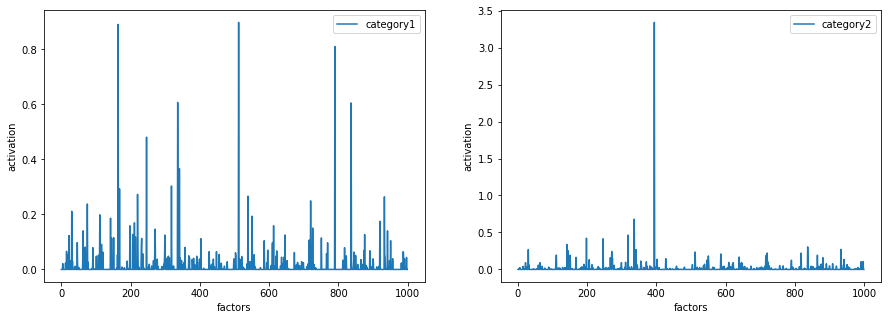

394 3.3407238 (1000,)


In [59]:
superlative_id = find_factor(ctg_adj, ctg_adjest)

In [60]:
superlative_id

394

(10,)


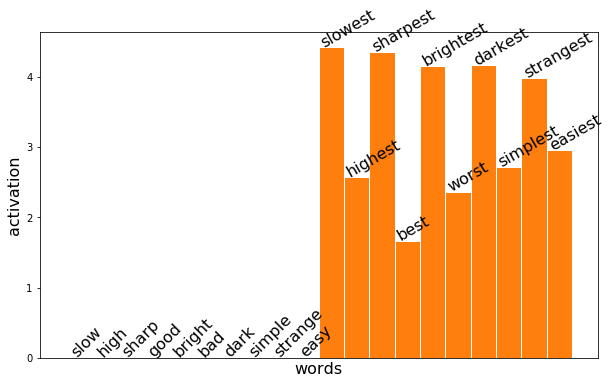

In [61]:
visualize_factor(ctg_adj, ctg_adjest, superlative_id)

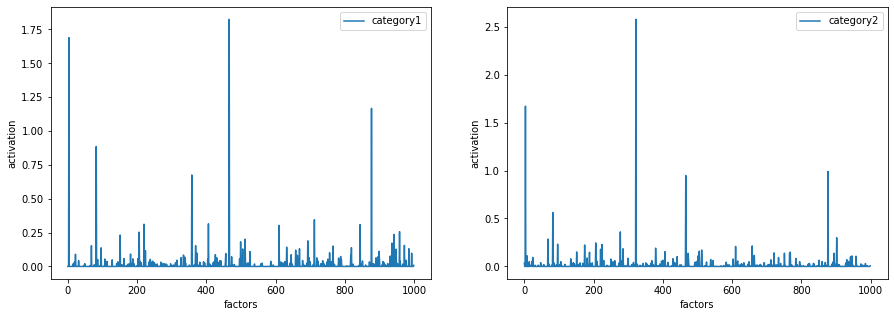

322 2.575643 (1000,)


In [62]:
female_id = find_factor(ctg_male, ctg_female)

(10,)


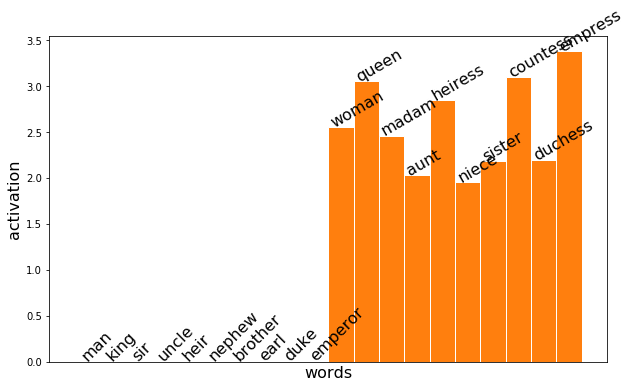

In [63]:
visualize_factor(ctg_male, ctg_female, female_id)

### word vector visualization

We show how to decompose and visualize a word vector using the learned factors

Lets radomly pick a word from the vocabulary and visualize its top factors that collectively takes up 80\% of the word's total activations

In [68]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from plotly.subplots import make_subplots

In [77]:
def decompose_word(word, ratio=0.8):
    word_id = vocab_idx[word]
    word_act = vocab_act[:, word_id].cpu()
    selected_factors = []
    factor_ratios = []
    accumu_ratio = 0.
    total_act = word_act.sum().item()
    sorted_factors = torch.argsort(word_act, descending=True)
    for fid in sorted_factors:
        act = word_act[fid].item()
        act_ratio = act / total_act
        accumu_ratio += act_ratio
        selected_factors.append(fid.item())
        factor_ratios.append(round(act_ratio,2))
        if accumu_ratio > ratio:
            break
    return word_id, selected_factors, factor_ratios

In [79]:
word_idx, factor_ids, factor_ratios = decompose_word("apple", ratio=0.8)

In [ ]:
ratio=0.8

In [65]:
label1 = ['Language','Programming','social']
value1 = [59,20.6,20.4]# 

In [94]:
def show_top_words(factor_id, topk=100):
    """Show top k activated words of a given factor """
    factor_act = vocab_act[factor_id,:].cpu()
    topk_idx = torch.argsort(factor_act, descending=True)[:topk]
    topk_words = [idx_vocab[idx.item()] for idx in topk_idx]
    return topk_words

In [109]:
def visualize_word(word, ratio=0.8):
    word_idx, factor_ids, factor_ratios = decompose_word(word, ratio)
    others = 1.0 - np.array(factor_ratios).sum()
    print(word, ratio, others)
    fig = go.Figure(data=[go.Pie(labels=factor_ids+["others"], values=factor_ratios+[others], hole=.6)])
    iplot(fig)
    return word_idx, factor_ids, factor_ratios

In [110]:
word_idx, factor_ids, factor_ratios = visualize_word("apple", ratio=0.8)

apple 0.8 0.16999999999999993


Naming of a factor is based on its top activated words, which we list following the way shown below:

In [111]:
for fid in factor_ids:
    print("factor <<{}>>'s top {} activated words".format(fid, 50))
    print(show_top_words(fid, topk=50))

factor <<389>>'s top 50 activated words
['jailbreak', 'ios', 'macbook', 'ipod', 'ibook', 'imac', 'kindle', 'siri', 'untethered', 'itunes', 'apple', 'nanos', 'ilife', 'macworld', 'nano', 'powerbook', 'imovie', 'xcode', 'ichat', 'nook', 'powermac', 'apps', 'baseband', 'airplay', 'mac', 'android', 'retina', 'oled', 'thunderbolt', 'osx', 'mackintosh', 'app', 'emac', 'applescript', 'multitasking', 'pwnage', 'os', 'macs', 'macintosh', 'wifi', 'adb', 'alexius', 'tether', 'xserve', 'tethered', 'wozniak', 'gen', 'dock', 'shuffle', 'tablet']
factor <<709>>'s top 50 activated words
['kumquat', 'quince', 'gooseberry', 'pomegranate', 'peaches', 'pear', 'fruit', 'pomegranates', 'apricot', 'mango', 'kiwifruit', 'plums', 'apricots', 'pears', 'seedless', 'peach', 'mangoes', 'satsuma', 'grapefruit', 'pineapple', 'raspberries', 'fruits', 'cherries', 'oranges', 'blueberries', 'kiwi', 'tangerine', 'clementine', 'melon', 'berry', 'blueberry', 'berries', 'plum', 'kumquats', 'marmalade', 'pectin', 'ripe', 'le

Another example:

In [119]:
word_idx, factor_ids, factor_ratios = visualize_word("best", ratio=0.8)
for fid in factor_ids:
    print("factor <<{}>>'s top {} activated words".format(fid, 50))
    print(show_top_words(fid, topk=50))

best 0.8 0.18999999999999995


factor <<512>>'s top 50 activated words
['her', 'into', 'out', 'up', 'over', 'back', 'down', 'off', 'his', 'him', 'with', 'every', 'through', 'for', 'without', 'own', 'in', 'making', 'together', 'next', 'take', 'their', 'from', 'and', 'home', 'full', 'takes', 'time', 'open', 'them', 'an', 'away', 'run', 'on', 'behind', 'taking', 'the', 'place', 'rest', 'end', 'before', 'a', 'under', 'to', 'around', 'world', 'coming', 'between', 'while', 'day']
factor <<394>>'s top 50 activated words
['driest', 'sunniest', 'ugliest', 'thickest', 'wettest', 'softest', 'loudest', 'handsomest', 'prettiest', 'happiest', 'densest', 'smartest', 'lightest', 'funniest', 'richest', 'shallowest', 'saddest', 'coldest', 'sweetest', 'tallest', 'rainiest', 'bloodiest', 'luckiest', 'slowest', 'safest', 'sexiest', 'sharpest', 'wisest', 'warmest', 'heaviest', 'darkest', 'blackest', 'coolest', 'brightest', 'toughest', 'shortest', 'deadliest', 'clearest', 'fairest', 'grandest', 'strangest', 'purest', 'longest', 'steepest'

## Step 4. Obtain cooccurrence matrix

In [120]:
sigma2 = (prob[None,:]*(vocab_act.cpu().numpy()**2)).sum(axis=1)
form2_a = vocab_act.cpu().numpy()/np.sqrt(sigma2)[:,None]
form2 = prob[None,:]*form2_a@form2_a.T

In [121]:
np.save(word_factor_dir+'nmed_factor_cooc.npy', form2)

## Step 5. Factor group visualization

Assume we get the cluster labels from spectral clustering, see the other notebook.

In [126]:
cluster_labels = np.load(word_factor_dir+"sym_labels_knn20_c175.npy")

In [127]:
print(cluster_labels.shape)

(1000,)


In [123]:
ctg_present = ['feeding', 'moving', 'playing', 'saying', 'vanishing', 'taking', 'predicting', 
        'listening', 'paying', 'sitting', 'falling', 'singing', 'going', 'seeing', 'walking', 
        'jumping', 'generating', 'increasing', 'running', 'sleeping', 'spending', 'describing', 
        'looking', 'reading', 'screaming', 'decreasing', 'flying', 'knowing', 'writing', 'implementing', 
        'dancing', 'hiding', 'striking', 'selling', 'enhancing', 'thinking', 'shrinking', 'swimming', 
        'hitting', 'slowing']
ctg_past = ['paid', 'flew', 'sold', 'went', 'listened', 'played', 'danced', 'increased', 'sang', 'sat', 
        'jumped', 'vanished', 'screamed', 'ran', 'moved', 'enhanced', 'read', 'wrote', 'swam', 
        'generated', 'shrank', 'implemented', 'decreased', 'slowed', 'hid', 'struck', 'said', 
        'looked', 'described', 'saw', 'spent', 'fell', 'thought', 'slept', 'walked', 'fed', 'hit', 
        'predicted', 'knew', 'took']

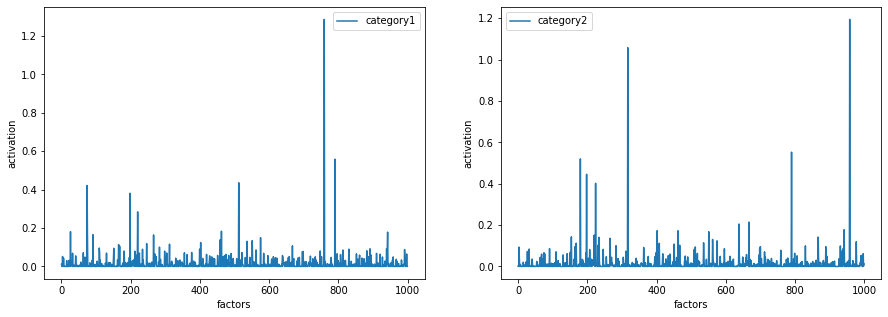

958 1.1946964 (1000,)


In [124]:
past_id = find_factor(ctg_present, ctg_past)

From above we can already see co-activation. Below we will draw out the cluster and visualize 

Find the factors that belongs to the same cluster

In [130]:
cl = cluster_labels[past_id]
print(cl)
same_cluster_ids = np.nonzero(cluster_labels==cl)[0]
print(same_cluster_ids)

54
[334 402 512 610 622 790 958]


In [135]:
def coact_visualization(ctg, factor_ids):
    ctg_idx = [vocab_idx[w] for w in ctg]
    ctg_act = vocab_act[:,ctg_idx].cpu().numpy()
    chunks = []
    chunk_ids = []
    ytick_colors = []
    for fid in factor_ids:
        chunks.append(ctg_act[fid-2:fid+3,:])
        chunk_ids.extend(np.arange(fid-2,fid+3).tolist())
        ytick_colors.extend(['b','b','r','b','b'])
    concat_acts = np.concatenate(chunks, axis=0)
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(concat_acts)
    ax.set_xticks(np.arange(ctg_act.shape[1]))
    ax.set_yticks(np.arange(len(chunk_ids)))
    ax.set_xticklabels(ctg, fontsize=16)
    ax.set_yticklabels(chunk_ids, fontsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), ytick_colors):
        ticklabel.set_color(tickcolor)
    ax.set_title("Activation Heat Map")
    fig.tight_layout()
    plt.show()

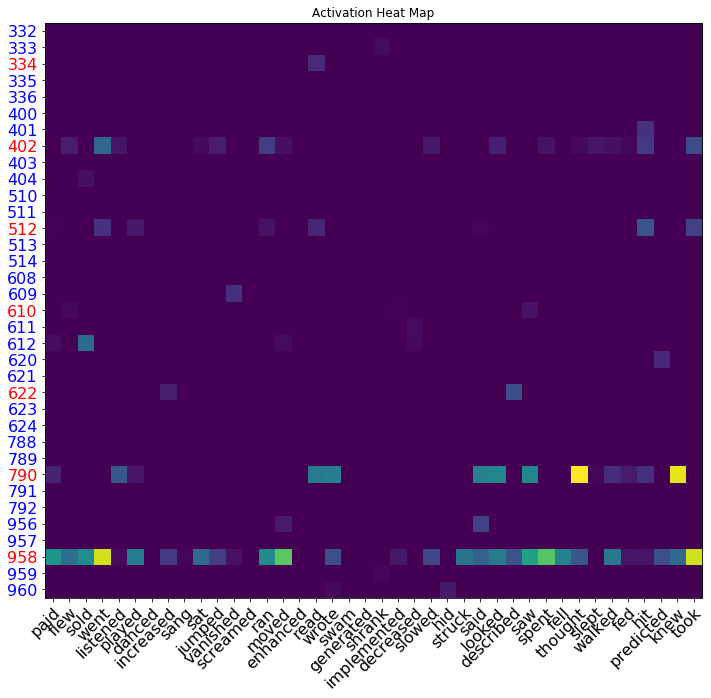

In [136]:
coact_visualization(ctg_past, same_cluster_ids)

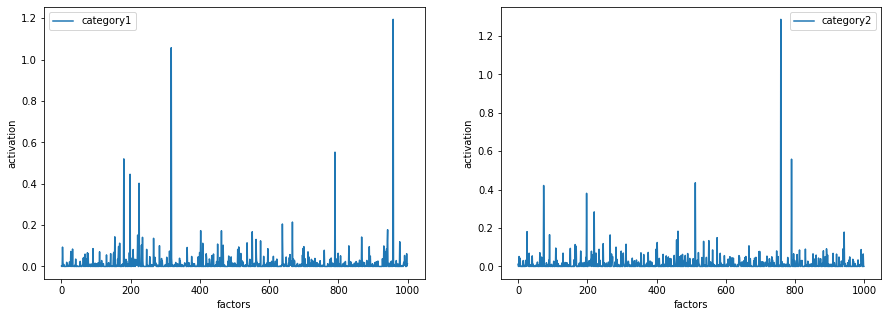

759 1.2866561 (1000,)


In [137]:
present_id = find_factor(ctg_past, ctg_present)

In [138]:
cl = cluster_labels[present_id]
print(cl)
same_cluster_ids = np.nonzero(cluster_labels==cl)[0]
print(same_cluster_ids)

130
[ 74 733 759]


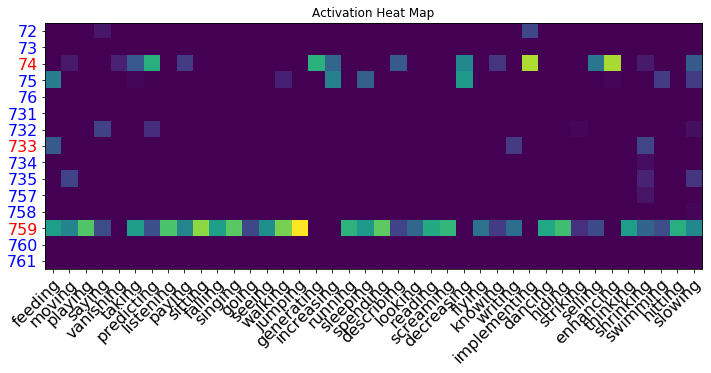

In [139]:
coact_visualization(ctg_present, same_cluster_ids)